## Import Libraries

In [1]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from mlxtend.frequent_patterns import apriori, association_rules
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

In [2]:
df = pd.read_csv('Recruitment_Transactions_ToBeDistributed.csv')

In [3]:
df.head()

,Unnamed: 0,the_transaction_id,the_date_transaction,sku_idr_sku,product_type,sports,but_name_business_unit,ctm_customer_id,the_to_type,f_qty_item,f_to_tax_in
0,1,7-1034-1034-20200708214026-101-8628,2020-07-08 21:40:26,0,NaN,NaN,City Square SG,NaN,offline,0,0.0
1,2,7-1034-1034-20200708164857-211-1734,2020-07-08 16:48:57,0,NaN,NaN,City Square SG,NaN,offline,0,0.0
2,3,7-1034-1034-20200701155410-102-6163,2020-07-01 15:54:10,0,NaN,NaN,City Square SG,NaN,offline,0,0.0
3,4,7-1034-1034-20200713202706-102-7516,2020-07-13 20:27:06,0,NaN,NaN,City Square SG,NaN,offline,0,0.0
4,5,7-1034-1034-20200727160812-211-4800,2020-07-27 16:08:12,0,NaN,NaN,City Square SG,NaN,offline,0,0.0


In [4]:
df.drop(columns= 'Unnamed: 0', axis = 1, inplace = True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5496751 entries, 0 to 5496750
Data columns (total 10 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   the_transaction_id      object 
 1   the_date_transaction    object 
 2   sku_idr_sku             int64  
 3   product_type            object 
 4   sports                  object 
 5   but_name_business_unit  object 
 6   ctm_customer_id         object 
 7   the_to_type             object 
 8   f_qty_item              int64  
 9   f_to_tax_in             float64
dtypes: float64(1), int64(2), object(7)
memory usage: 419.4+ MB


In [6]:
df.describe()

,sku_idr_sku,f_qty_item,f_to_tax_in
count,5.496751e+06,5.496751e+06,5.496751e+06
mean,5.803890e+06,2.979526e+00,6.196055e+01
std,2.466495e+06,1.518516e+00,5.752038e+01
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.500415e+06,2.000000e+00,2.400000e+01
50%,7.204275e+06,3.000000e+00,4.000000e+01
75%,7.328256e+06,4.000000e+00,8.550000e+01
max,7.542224e+06,5.010000e+02,4.318000e+03


In [7]:
print(df.isnull().sum())

the_transaction_id              0
the_date_transaction            0
sku_idr_sku                     0
product_type                  878
sports                        656
but_name_business_unit          0
ctm_customer_id           2059281
the_to_type                     0
f_qty_item                      0
f_to_tax_in                     0
dtype: int64


## Data Exploration

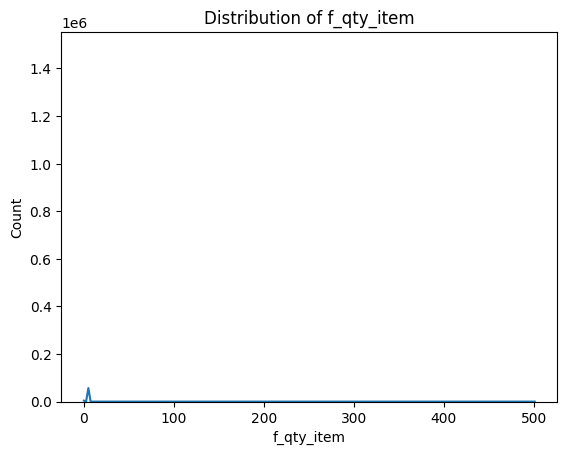

In [8]:
sb.histplot(df['f_qty_item'], kde=True)
plt.title('Distribution of f_qty_item')
plt.show()



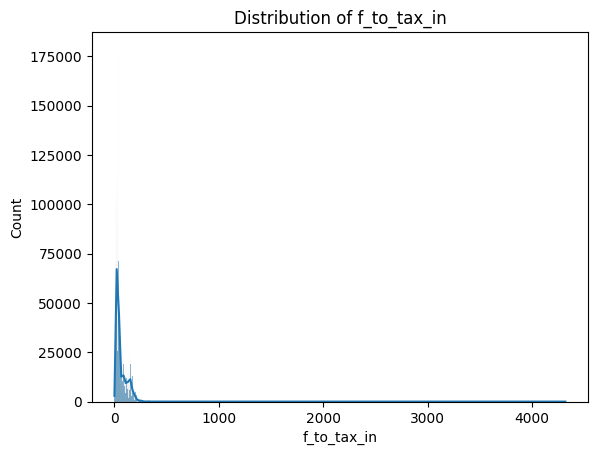

In [9]:
sb.histplot(df['f_to_tax_in'], kde=True)
plt.title('Distribution of f_to_tax_in')
plt.show()

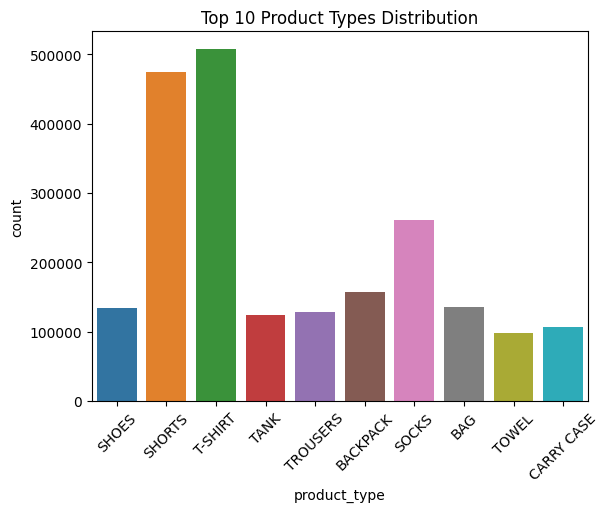

In [10]:
top_n = 10  
top_product_types = df['product_type'].value_counts().nlargest(top_n).index

sb.countplot(x='product_type', data=df[df['product_type'].isin(top_product_types)])
plt.title(f'Top {top_n} Product Types Distribution')
plt.xticks(rotation=45)
plt.show()

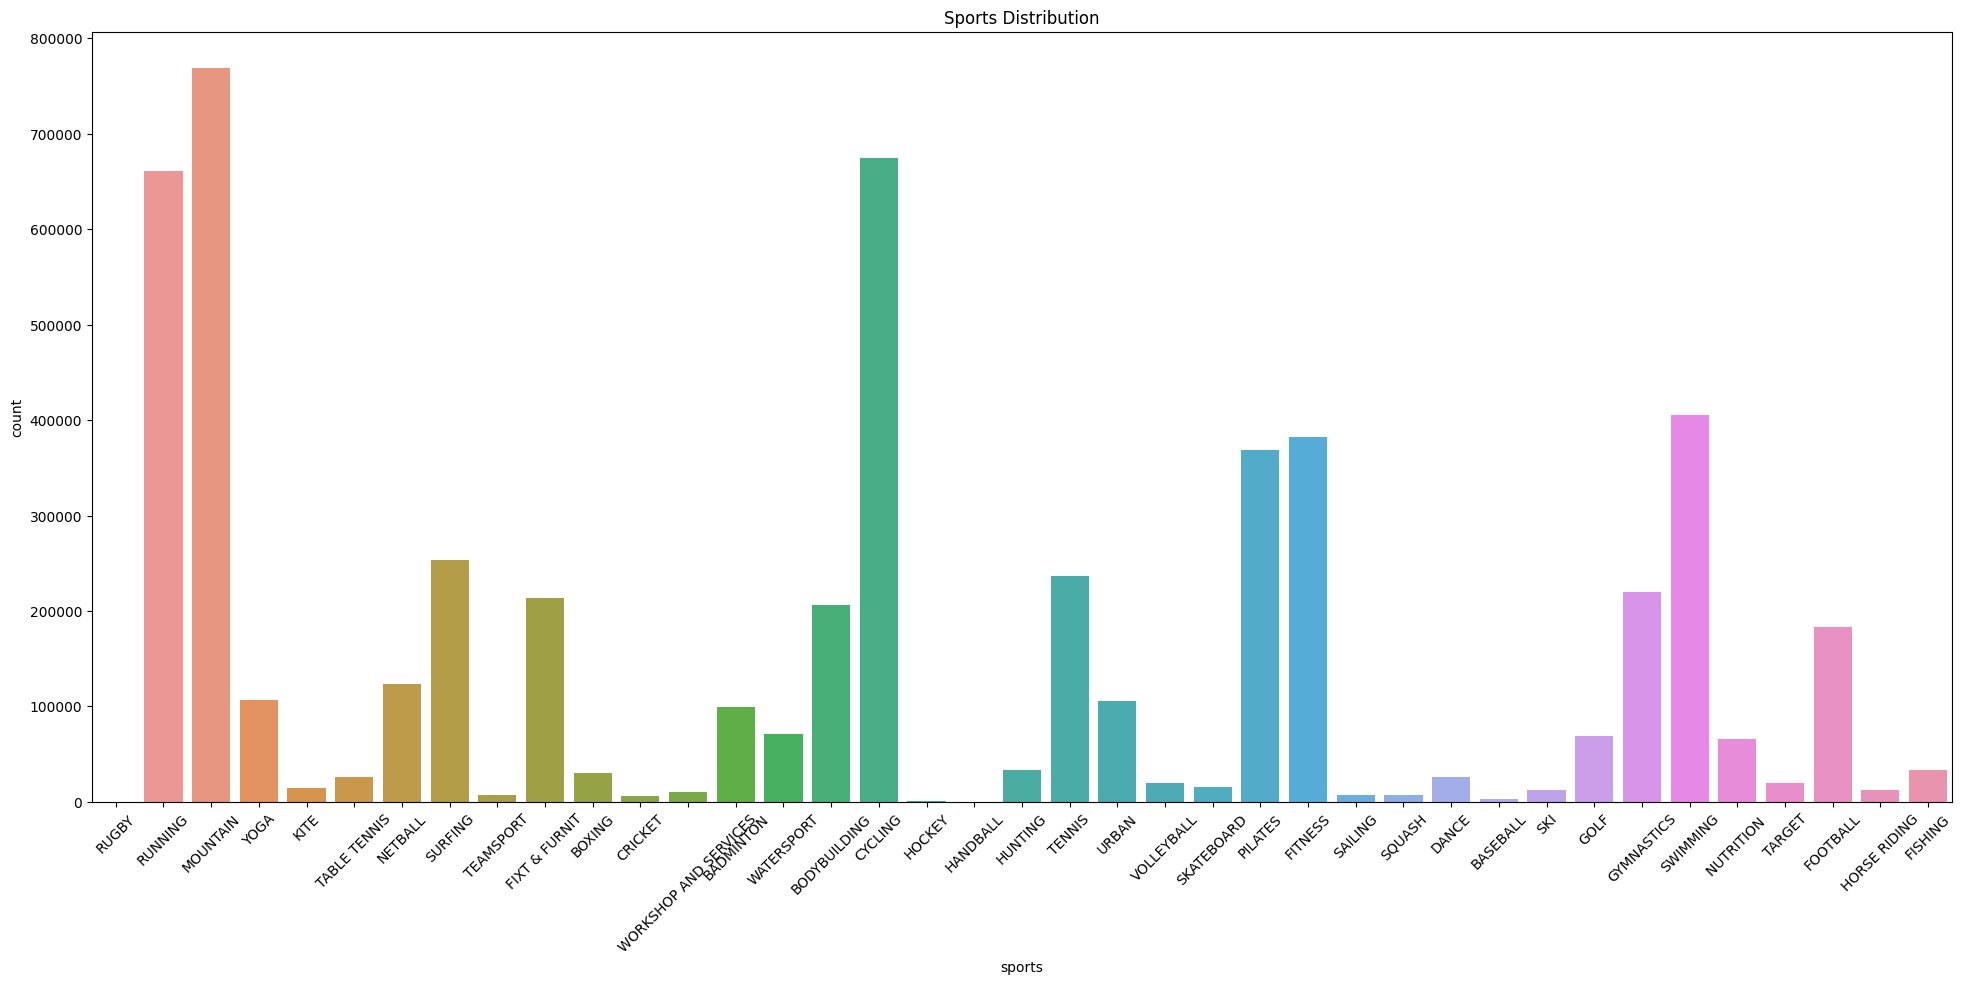

In [11]:
plt.figure(figsize = (24,10))
sb.countplot(x='sports', data=df)
plt.title('Sports Distribution')
plt.xticks(rotation=45)
plt.show()

## Average basket size and basket value of members and non members per store

Segregating member and non-member transactions

In [12]:
df_not_ctm = df.loc[df['ctm_customer_id'].isnull()]

In [13]:
df_not_ctm

,the_transaction_id,the_date_transaction,sku_idr_sku,product_type,sports,but_name_business_unit,ctm_customer_id,the_to_type,f_qty_item,f_to_tax_in
0,7-1034-1034-20200708214026-101-8628,2020-07-08 21:40:26,0,NaN,NaN,City Square SG,NaN,offline,0,0.0
1,7-1034-1034-20200708164857-211-1734,2020-07-08 16:48:57,0,NaN,NaN,City Square SG,NaN,offline,0,0.0
2,7-1034-1034-20200701155410-102-6163,2020-07-01 15:54:10,0,NaN,NaN,City Square SG,NaN,offline,0,0.0
3,7-1034-1034-20200713202706-102-7516,2020-07-13 20:27:06,0,NaN,NaN,City Square SG,NaN,offline,0,0.0
4,7-1034-1034-20200727160812-211-4800,2020-07-27 16:08:12,0,NaN,NaN,City Square SG,NaN,offline,0,0.0
...,...,...,...,...,...,...,...,...,...,...
5496736,7-969-969-20201221181336-210-8719,2020-12-21 18:13:36,597350,SOCKS,RUNNING,Bedok SG,NaN,offline,3,92.0
5496737,7-969-969-20201221181336-210-8719,2020-12-21 18:13:36,597350,SOCKS,RUNNING,Bedok SG,NaN,offline,6,92.0
5496738,7-969-969-20201221181336-210-8719,2020-12-21 18:13:36,597350,SOCKS,RUNNING,Bedok SG,NaN,offline,8,92.0
5496741,7-969-969-20201224141216-209-4124,2020-12-24 14:12:16,7145826,SHOES,RUNNING,Bedok SG,NaN,offline,2,76.0


Removing rows that does not have value and quantity which will affect the average scores <br>
Removing sku_idr_sku that is 0 which means that there is no product ID and the product does not exist

In [14]:
df_not_ctm.query("f_qty_item == 0 & f_to_tax_in == 0").head()

,the_transaction_id,the_date_transaction,sku_idr_sku,product_type,sports,but_name_business_unit,ctm_customer_id,the_to_type,f_qty_item,f_to_tax_in
0,7-1034-1034-20200708214026-101-8628,2020-07-08 21:40:26,0,NaN,NaN,City Square SG,NaN,offline,0,0.0
1,7-1034-1034-20200708164857-211-1734,2020-07-08 16:48:57,0,NaN,NaN,City Square SG,NaN,offline,0,0.0
2,7-1034-1034-20200701155410-102-6163,2020-07-01 15:54:10,0,NaN,NaN,City Square SG,NaN,offline,0,0.0
3,7-1034-1034-20200713202706-102-7516,2020-07-13 20:27:06,0,NaN,NaN,City Square SG,NaN,offline,0,0.0
4,7-1034-1034-20200727160812-211-4800,2020-07-27 16:08:12,0,NaN,NaN,City Square SG,NaN,offline,0,0.0


In [15]:
df_not_ctm = df_not_ctm.loc[df_not_ctm['sku_idr_sku'] != 0]
df_not_ctm = df_not_ctm.loc[(df_not_ctm['f_qty_item'] != 0) & (df_not_ctm['f_to_tax_in'] != 0) ]

In [16]:
df_not_ctm

,the_transaction_id,the_date_transaction,sku_idr_sku,product_type,sports,but_name_business_unit,ctm_customer_id,the_to_type,f_qty_item,f_to_tax_in
53,7-1034-1034-20200829140007-102-4073,2020-08-29 14:00:07,634928,NaN,NaN,City Square SG,NaN,offline,3,121.5
656,7-2128-2128-20201128223450-101-8145,2020-11-28 22:34:50,1795606,UNDEFINED,RUGBY,Singapore Lab,NaN,offline,4,45.0
657,7-1034-1034-20200702133138-212-6643,2020-07-02 13:31:38,7200628,SHOES,RUNNING,City Square SG,NaN,offline,3,112.0
658,7-1034-1034-20200701183058-213-952,2020-07-01 18:30:58,7204159,WATER BAG,RUNNING,City Square SG,NaN,offline,3,218.0
659,7-1034-1034-20200701151855-215-8375,2020-07-01 15:18:55,7009513,SUNGLASSES,RUNNING,City Square SG,NaN,offline,2,41.5
...,...,...,...,...,...,...,...,...,...,...
5496736,7-969-969-20201221181336-210-8719,2020-12-21 18:13:36,597350,SOCKS,RUNNING,Bedok SG,NaN,offline,3,92.0
5496737,7-969-969-20201221181336-210-8719,2020-12-21 18:13:36,597350,SOCKS,RUNNING,Bedok SG,NaN,offline,6,92.0
5496738,7-969-969-20201221181336-210-8719,2020-12-21 18:13:36,597350,SOCKS,RUNNING,Bedok SG,NaN,offline,8,92.0
5496741,7-969-969-20201224141216-209-4124,2020-12-24 14:12:16,7145826,SHOES,RUNNING,Bedok SG,NaN,offline,2,76.0


In [17]:
store_grouped = df_not_ctm.groupby('but_name_business_unit').agg(
    average_basket_size=('f_qty_item', 'mean'),
    average_basket_value=('f_to_tax_in', 'mean')
)

# Print the average basket size and average basket value per store
for store_name, store_data in store_grouped.iterrows():
    print(f"Store: {store_name}")
    print(f"Average Basket Size: {store_data['average_basket_size']:.2f}")
    print(f"Average Basket Value: ${store_data['average_basket_value']:.2f}")
    print()

Store: Bedok SG
Average Basket Size: 2.97
Average Basket Value: $61.37

Store: Centre Point
Average Basket Size: 2.97
Average Basket Value: $58.80

Store: Chinatown Point
Average Basket Size: 2.96
Average Basket Value: $59.98

Store: City Square SG
Average Basket Size: 2.96
Average Basket Value: $60.85

Store: Decathlon Holland Village
Average Basket Size: 2.96
Average Basket Value: $64.01

Store: Decathlon Velocity
Average Basket Size: 2.97
Average Basket Value: $59.85

Store: Joo Koon
Average Basket Size: 2.97
Average Basket Value: $59.17

Store: Singapore Lab
Average Basket Size: 2.98
Average Basket Value: $61.56

Store: SunPlaza
Average Basket Size: 2.95
Average Basket Value: $60.65

Store: Tampines Mall
Average Basket Size: 2.97
Average Basket Value: $58.46

Store: Tiong Bahru Plaza
Average Basket Size: 2.96
Average Basket Value: $57.70

Store: Waterway Point
Average Basket Size: 2.95
Average Basket Value: $62.47

Store: Website
Average Basket Size: 3.00
Average Basket Value: $66.

It is observed that online website have the largest average basket size and basket value for Non-Member Customers. <br>
Some possible reasons could be due to: <br>
- Convenience in Online Shopping
- Delivery of items 
- more attractive deals 
- better marketing of products

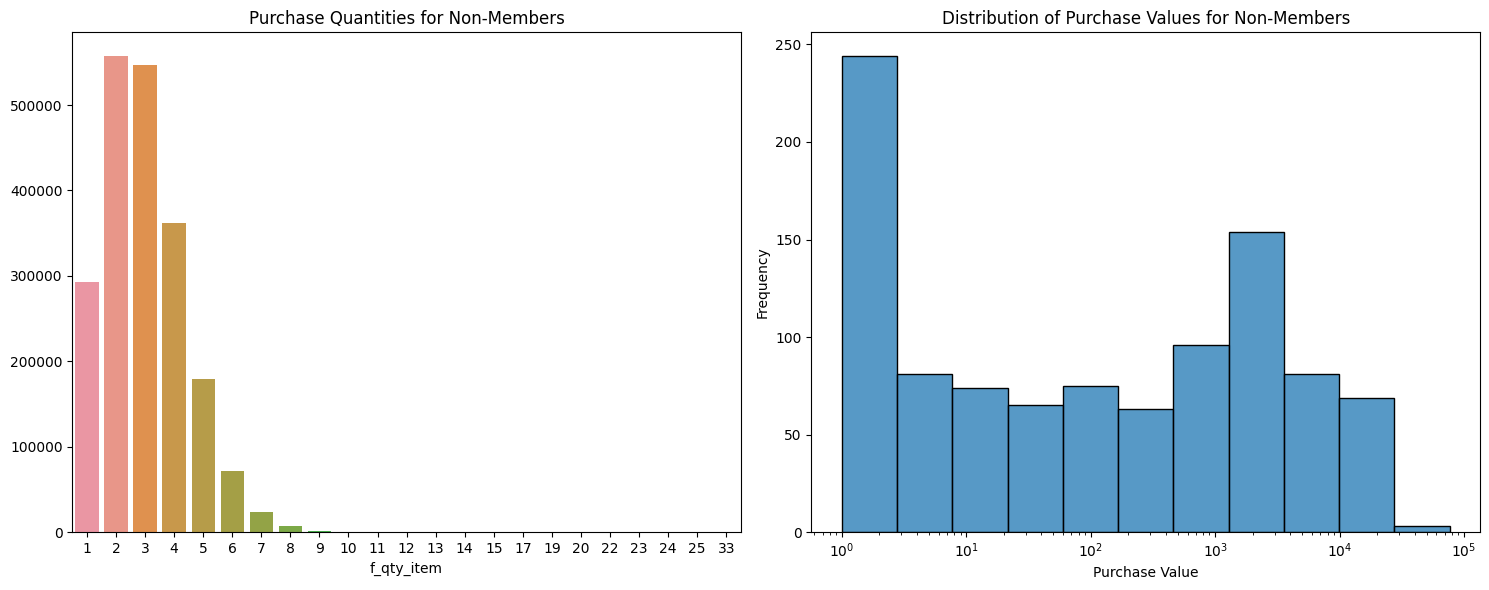

In [18]:
members_purchase = df_not_ctm['f_qty_item'].value_counts()
members_purchase_val = df_not_ctm['f_to_tax_in'].value_counts()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

sb.barplot(x=members_purchase.index, y=members_purchase.values, ax=axes[0])
axes[0].set_title("Purchase Quantities for Non-Members")


sb.histplot(members_purchase_val, ax=axes[1],log_scale=(True, False))
axes[1].set_title("Distribution of Purchase Values for Non-Members")
axes[1].set_xlabel("Purchase Value")
axes[1].set_ylabel("Frequency")

# Adjust layout
plt.tight_layout()
plt.show()


The barplot and histogram shows the distribution of f_qty_item and f_to_tax_in that the Non-Member's transaction.<br> It is most common for non-members to purchase 2-3 items and spend <$10 

In [19]:
df_ctm = df.loc[~df['ctm_customer_id'].isnull()]

In [20]:
df_ctm = df_ctm.loc[df_ctm['sku_idr_sku']!= 0]
df_ctm = df_ctm.loc[(df_ctm['f_qty_item'] != 0) & (df_ctm['f_to_tax_in'] != 0) ]

In [21]:
average_basket_size_member = df_ctm['f_qty_item'].mean()
average_basket_value_member = df_ctm['f_to_tax_in'].mean()

In [22]:
store_grouped = df_ctm.groupby('but_name_business_unit').agg(
    average_basket_size=('f_qty_item', 'mean'),
    average_basket_value=('f_to_tax_in', 'mean')
)

# Print the average basket size and average basket value per store
for store_name, store_data in store_grouped.iterrows():
    print(f"Store: {store_name}")
    print(f"Average Basket Size: {store_data['average_basket_size']:.2f}")
    print(f"Average Basket Value: ${store_data['average_basket_value']:.2f}")
    print()

Store: Bedok SG
Average Basket Size: 2.98
Average Basket Value: $61.71

Store: Centre Point
Average Basket Size: 2.98
Average Basket Value: $59.47

Store: Chinatown Point
Average Basket Size: 2.97
Average Basket Value: $57.73

Store: City Square SG
Average Basket Size: 2.98
Average Basket Value: $60.72

Store: Decathlon Holland Village
Average Basket Size: 2.98
Average Basket Value: $63.01

Store: Decathlon Velocity
Average Basket Size: 2.98
Average Basket Value: $59.74

Store: Joo Koon
Average Basket Size: 2.98
Average Basket Value: $59.54

Store: Singapore Lab
Average Basket Size: 2.99
Average Basket Value: $61.21

Store: SunPlaza
Average Basket Size: 2.96
Average Basket Value: $60.58

Store: Tampines Mall
Average Basket Size: 2.97
Average Basket Value: $58.83

Store: Tiong Bahru Plaza
Average Basket Size: 2.98
Average Basket Value: $57.22

Store: Waterway Point
Average Basket Size: 2.96
Average Basket Value: $60.58

Store: Website
Average Basket Size: 3.19
Average Basket Value: $74.

It is observed that online website have the largest average basket size and basket value for Member Customers. <br>
Some possible reasons could be due to: <br>
- Convenience in Online Shopping
- Products readily available online compared to physical stores
- Delivery of items 
- more attractive deals 
- better marketing of products
- Member online benefits

It is also observed that members that uses the online store website have a higher average basket size and average basket value

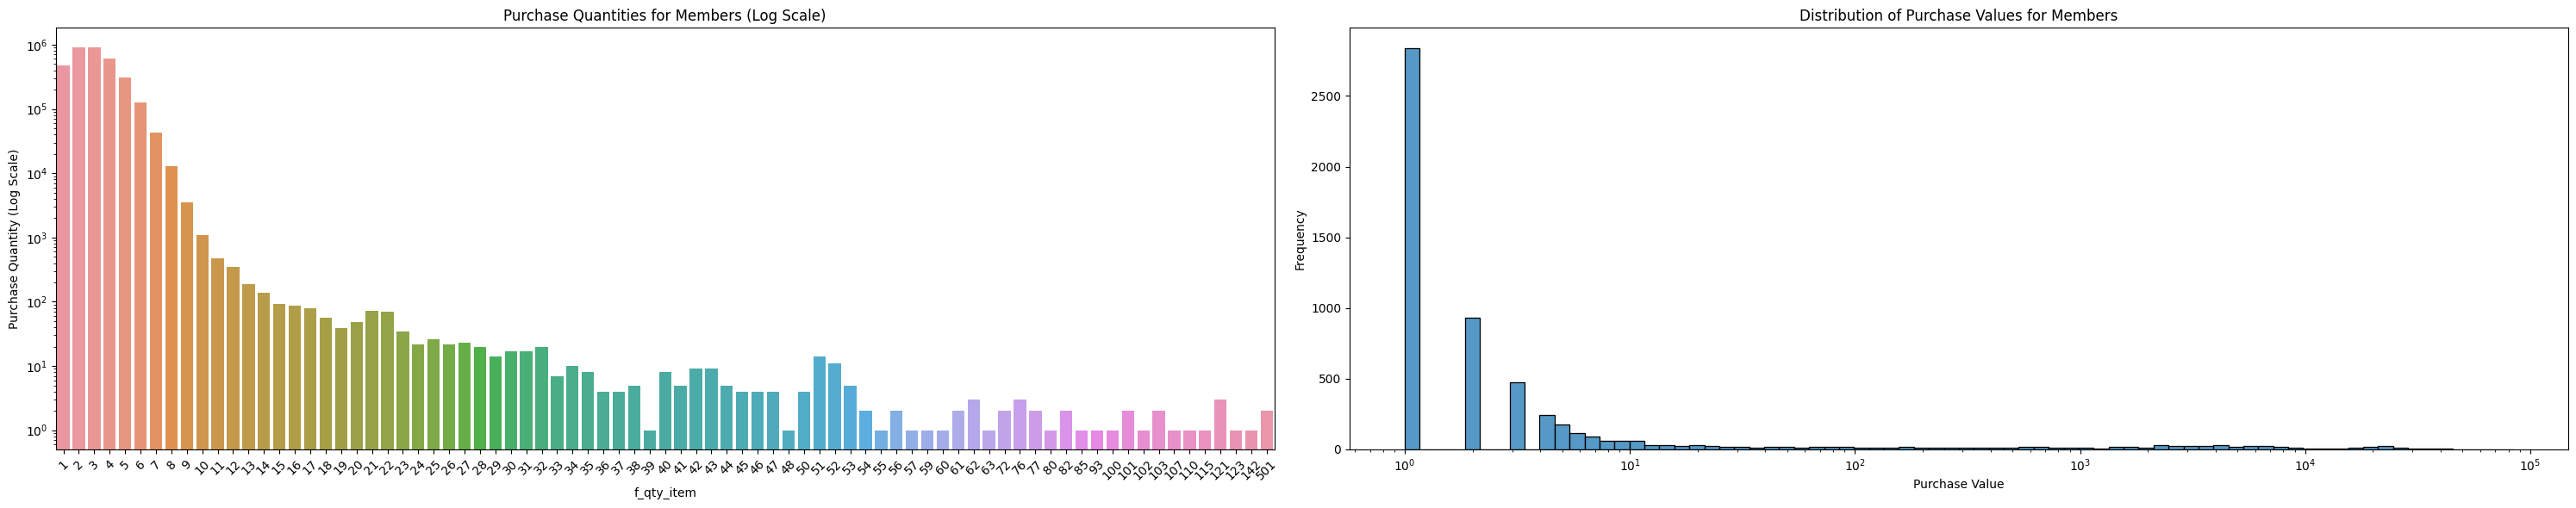

In [23]:
members_purchase = df_ctm['f_qty_item'].value_counts()
members_purchase_val = df_ctm['f_to_tax_in'].value_counts()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30, 6))

sb.barplot(x=members_purchase.index, y=members_purchase.values, ax=axes[0])
axes[0].set_yscale("log")  # Apply logarithmic y-scale
axes[0].set_title("Purchase Quantities for Members (Log Scale)")
axes[0].set_ylabel("Purchase Quantity (Log Scale)")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)


sb.histplot(members_purchase_val, ax=axes[1],log_scale=(True, False))
axes[1].set_title("Distribution of Purchase Values for Members")
axes[1].set_xlabel("Purchase Value")
axes[1].set_ylabel("Frequency")

# Adjust layout
plt.tight_layout()
plt.show()

The barplot and histogram shows the distribution of f_qty_item and f_to_tax_in that the Member's transaction. <br>
It is more common for members to buy 1-4 items. 

## Three Channels Problem

In [24]:
df['but_name_business_unit'].unique()

array(['City Square SG', 'Joo Koon', 'Website', 'Decathlon Velocity',
       'Decathlon Holland Village', 'Singapore Lab', 'Centre Point',
       'SunPlaza', 'Waterway Point', 'Tampines Mall', 'Chinatown Point',
       'Tiong Bahru Plaza', 'Bedok SG'], dtype=object)

First identify the different unique business stores that Decathlon has.

Every but_name_business_unit are mapped to their respective store types which are:
- Experience Stores
- C&C 
- Online

In [25]:
store_dict = {}
store_dict['City Square SG'] = 'Experience Stores'
store_dict['Joo Koon'] = 'Experience Stores'
store_dict['Website'] = 'Online'
store_dict['Decathlon Velocity'] = 'C&C Stores'
store_dict['Decathlon Holland Village'] = 'C&C Stores'
store_dict['Singapore Lab'] = 'Experience Stores'
store_dict['Centre Point'] = 'Experience Stores'
store_dict['SunPlaza'] = 'C&C Stores'
store_dict['Waterway Point'] = 'C&C Stores'
store_dict['Tampines Mall'] = 'C&C Stores'
store_dict['Chinatown Point'] = 'C&C Stores'
store_dict['Tiong Bahru Plaza'] = 'C&C Stores'
store_dict['Bedok SG'] = 'Experience Stores'


In [26]:
df_ctm.sort_values('ctm_customer_id')

,the_transaction_id,the_date_transaction,sku_idr_sku,product_type,sports,but_name_business_unit,ctm_customer_id,the_to_type,f_qty_item,f_to_tax_in
1566909,7-2128-2128-20200729183354-207-90,2020-07-29 18:33:54,1719786,SADDLE BAG,CYCLING,Singapore Lab,000DFTLRKY,offline,2,12.5
5369129,7-2128-2128-20200717183538-206-2876,2020-07-17 18:35:38,7234253,HELMET,CYCLING,Singapore Lab,000DFTLRKY,offline,4,163.5
4723281,7-2128-2128-20200717183538-206-2876,2020-07-17 18:35:38,379525,BELL,CYCLING,Singapore Lab,000DFTLRKY,offline,2,6.0
2688874,7-2128-2128-20200729183354-207-90,2020-07-29 18:33:54,2355580,FLOOR PUMP,CYCLING,Singapore Lab,000DFTLRKY,offline,3,55.0
5366542,7-2128-2128-20200729183354-207-90,2020-07-29 18:33:54,1779638,PADDED CYCLING,CYCLING,Singapore Lab,000DFTLRKY,offline,2,123.0
...,...,...,...,...,...,...,...,...,...,...
5439683,7-1034-1034-20200919181651-214-8784,2020-09-19 18:16:51,7005146,SCALE,RUNNING,City Square SG,ZZZUB8CDE9,offline,2,82.5
5439682,7-1034-1034-20200919181651-214-8784,2020-09-19 18:16:51,2035618,SHOES,RUNNING,City Square SG,ZZZUB8CDE9,offline,2,29.0
1316808,7-1871-1871-20200920174926-207-2315,2020-09-20 17:49:26,7263424,SHOES,RUNNING,Joo Koon,ZZZZBP6S27,offline,5,54.0
4050744,7-1871-1871-20200920174926-207-2315,2020-09-20 17:49:26,2331274,SANDALS,SWIMMING,Joo Koon,ZZZZBP6S27,offline,1,36.5


Merging the DataFrame to the mapped dictionary

In [27]:
df_ctm = df_ctm.merge(pd.DataFrame(store_dict.items(), columns=['but_name_business_unit', 'StoreType']), on='but_name_business_unit', how='left')

In [28]:
result = df_ctm.groupby('ctm_customer_id')['StoreType'].agg(set).reset_index()

In [29]:
print(result)

       ctm_customer_id                                StoreType
0           000DFTLRKY                      {Experience Stores}
1           000FX6RHTM                      {Experience Stores}
2           000NZ1KH93          {C&C Stores, Experience Stores}
3           000R842PBV                                 {Online}
4           0014SWGO7X                      {Experience Stores}
...                ...                                      ...
384725      ZZZMIYQG58                      {Experience Stores}
384726      ZZZPD2IMD6                                 {Online}
384727      ZZZS1QUNOD                      {Experience Stores}
384728      ZZZUB8CDE9  {C&C Stores, Experience Stores, Online}
384729      ZZZZBP6S27                      {Experience Stores}

[384730 rows x 2 columns]


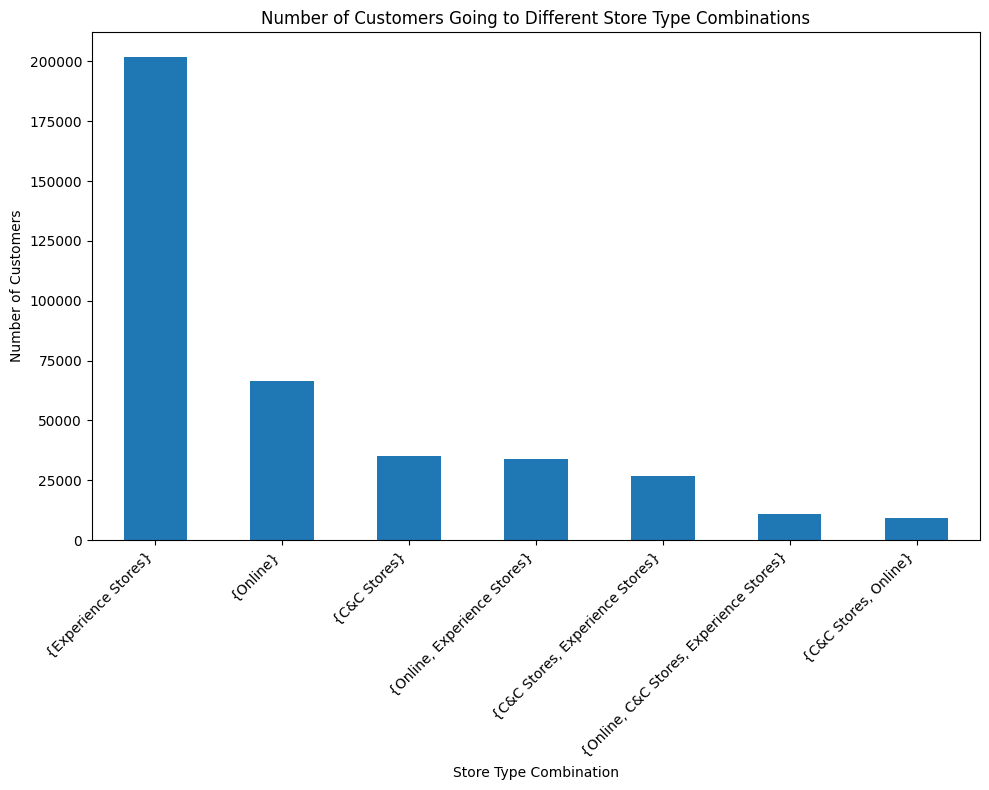

In [30]:
customer_storetype = result['StoreType'].value_counts()
plt.figure(figsize = (10,8))
customer_storetype.plot(kind = 'bar')

plt.xlabel('Store Type Combination')
plt.ylabel('Number of Customers')
plt.title('Number of Customers Going to Different Store Type Combinations')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

The barplot shows that most customers only made purcahses in the experiences stores only. 

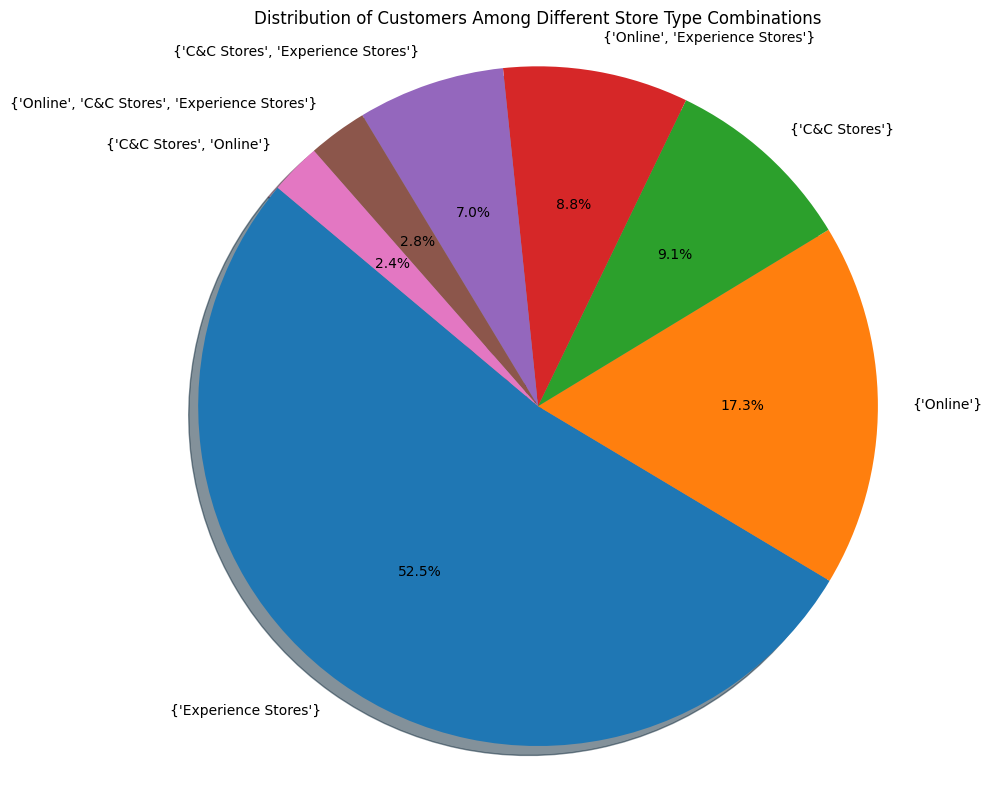

In [31]:
plt.figure(figsize = (10,8))
plt.pie(customer_storetype, labels = customer_storetype.index, autopct = '%1.1f%%', startangle = 140, shadow = True)
plt.title('Distribution of Customers Among Different Store Type Combinations')
plt.axis('equal') 
plt.tight_layout()
plt.show()

In [32]:
customer_storetype


StoreType
{Experience Stores}                        202072
{Online}                                    66455
{C&C Stores}                                35182
{Online, Experience Stores}                 33919
{C&C Stores, Experience Stores}             26941
{Online, C&C Stores, Experience Stores}     10826
{C&C Stores, Online}                         9335
Name: count, dtype: int64

In [33]:
total_customers = len(result)
customer_percentages = (customer_storetype/total_customers)*100
print("Percentage of customers for each store type:")
print(customer_percentages)

Percentage of customers for each store type:
StoreType
{Experience Stores}                        52.523068
{Online}                                   17.273153
{C&C Stores}                                9.144595
{Online, Experience Stores}                 8.816313
{C&C Stores, Experience Stores}             7.002573
{Online, C&C Stores, Experience Stores}     2.813921
{C&C Stores, Online}                        2.426377
Name: count, dtype: float64


## Popular Timings for purchases in stores

The df needs to be cleaned by: <li>removing but_name_business_unit 'online' <li> sku_idr_sku == 0 which mean no product id <li> removing f_qty_item == 0 and f_to_tax_in == 0 which meant that no transaction of any value and product occured.

In [34]:
df = df.loc[df['but_name_business_unit'] != 'online']
df = df.loc[df['sku_idr_sku'] != 0]
df = df.loc[(df['f_qty_item'] != 0) & (df['f_to_tax_in'] != 0)]

To convert object to date_time object

In [35]:
df['the_date_transaction'] = pd.to_datetime(df['the_date_transaction'])

Utilise the hours to identify which is the most popular time where people purchase products

In [36]:
df['hour'] = df['the_date_transaction'].dt.hour

In [37]:
transaction_counts = df.groupby(['hour']).size().reset_index(name='count')

In [38]:
transaction_counts

,hour,count
0,0,1896
1,1,39
2,2,58
3,3,5
4,4,15
5,6,6
6,7,280
7,8,22189
8,9,54159
9,10,169634


#### Calculated for all store_types

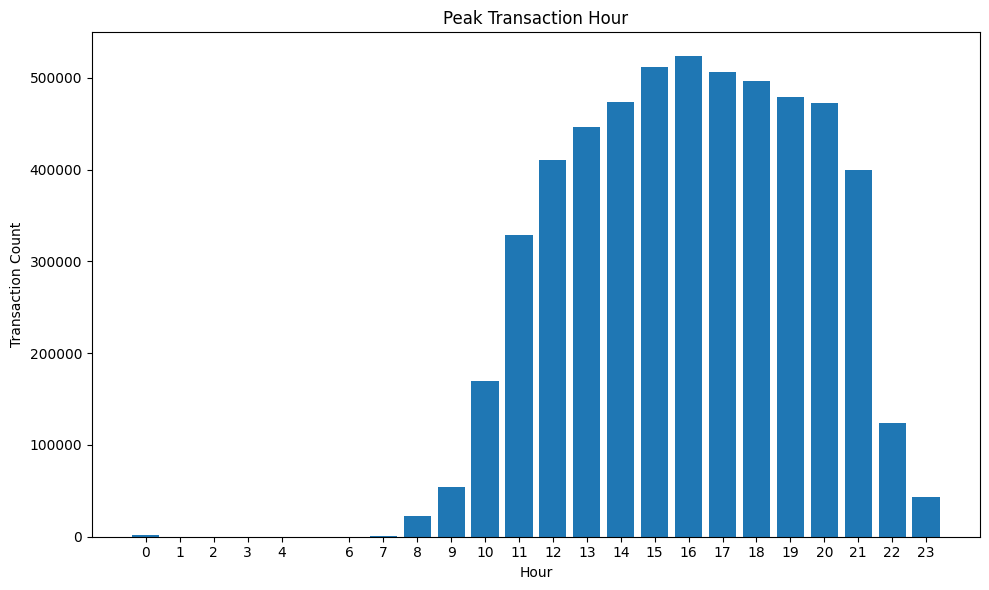

In [39]:
plt.figure(figsize=(10, 6))
plt.bar(transaction_counts['hour'], transaction_counts['count'])
plt.xlabel('Hour')
plt.ylabel('Transaction Count')
plt.title('Peak Transaction Hour')
plt.xticks(transaction_counts['hour'])
plt.tight_layout()

In [40]:
peak_time = transaction_counts.loc[transaction_counts['count'].idxmax()]

print("Peak Time:", peak_time['hour'], "hours", "with", peak_time['count'], "transactions")

Peak Time: 16 hours with 523259 transactions


In [41]:
df['store_type'] = df['but_name_business_unit'].map(store_dict)

In [42]:
df_market = df.copy()

### Identify the different popular timings for different store types

In [43]:
df_exp_stores = df[df['store_type'] == "Experience Stores"]
df_cc_stores = df[df['store_type'] == "C&C Stores"]
df_online= df[df['store_type'] == "Online"]

In [44]:
df_exp_stores.head()

,the_transaction_id,the_date_transaction,sku_idr_sku,product_type,sports,but_name_business_unit,ctm_customer_id,the_to_type,f_qty_item,f_to_tax_in,hour,store_type
53,7-1034-1034-20200829140007-102-4073,2020-08-29 14:00:07,634928,NaN,NaN,City Square SG,NaN,offline,3,121.5,14,Experience Stores
91,7-1034-1034-20201006104818-102-705,2020-10-06 10:48:18,2014743,NaN,NaN,City Square SG,8VSGYLTXL2,offline,1,29.5,10,Experience Stores
656,7-2128-2128-20201128223450-101-8145,2020-11-28 22:34:50,1795606,UNDEFINED,RUGBY,Singapore Lab,NaN,offline,4,45.0,22,Experience Stores
657,7-1034-1034-20200702133138-212-6643,2020-07-02 13:31:38,7200628,SHOES,RUNNING,City Square SG,NaN,offline,3,112.0,13,Experience Stores
658,7-1034-1034-20200701183058-213-952,2020-07-01 18:30:58,7204159,WATER BAG,RUNNING,City Square SG,NaN,offline,3,218.0,18,Experience Stores


In [45]:
transaction_counts = df_exp_stores.groupby(['hour']).size().reset_index(name='count')
peak_time_exp = transaction_counts.loc[transaction_counts['count'].idxmax()]

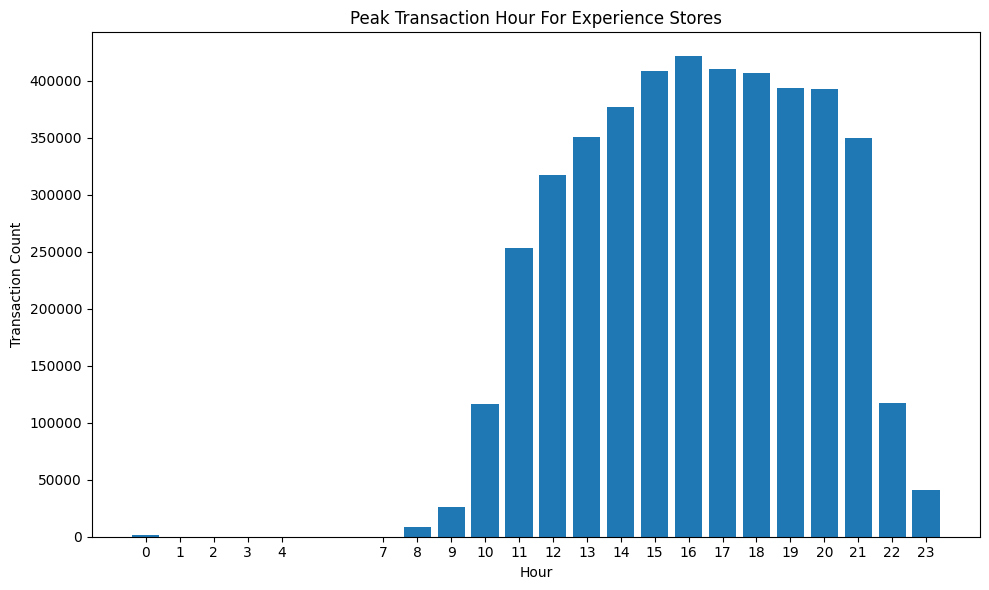

In [46]:
plt.figure(figsize=(10, 6))
plt.bar(transaction_counts['hour'], transaction_counts['count'])
plt.xlabel('Hour')
plt.ylabel('Transaction Count')
plt.title('Peak Transaction Hour For Experience Stores')
plt.xticks(transaction_counts['hour'])
plt.tight_layout()

In [47]:
df_cc_stores.head()

,the_transaction_id,the_date_transaction,sku_idr_sku,product_type,sports,but_name_business_unit,ctm_customer_id,the_to_type,f_qty_item,f_to_tax_in,hour,store_type
3970,7-1979-1979-20200712151047-203-5397,2020-07-12 15:10:47,7207287,SUNGLASSES,RUNNING,Decathlon Holland Village,AO886MVE0M,offline,4,43.5,15,C&C Stores
3996,7-1979-1979-20200703200123-203-3559,2020-07-03 20:01:23,7201659,SHORTS,RUNNING,Decathlon Holland Village,NaN,offline,3,27.0,20,C&C Stores
4021,7-1979-1979-20200807192016-203-963,2020-08-07 19:20:16,6912034,WATER POUCH,RUNNING,Decathlon Holland Village,VV6BW9TGKK,offline,3,20.0,19,C&C Stores
4022,7-1979-1979-20200810121030-203-1547,2020-08-10 12:10:30,7201659,SHORTS,RUNNING,Decathlon Holland Village,J1UQ9VHX6C,offline,5,27.0,12,C&C Stores
4024,7-1979-1979-20201108121410-203-8336,2020-11-08 12:14:10,7202910,RUNNING MID TIG,RUNNING,Decathlon Holland Village,NaN,offline,3,51.0,12,C&C Stores


In [48]:
transaction_counts = df_cc_stores.groupby(['hour']).size().reset_index(name='count')

peak_time_cc = transaction_counts.loc[transaction_counts['count'].idxmax()]

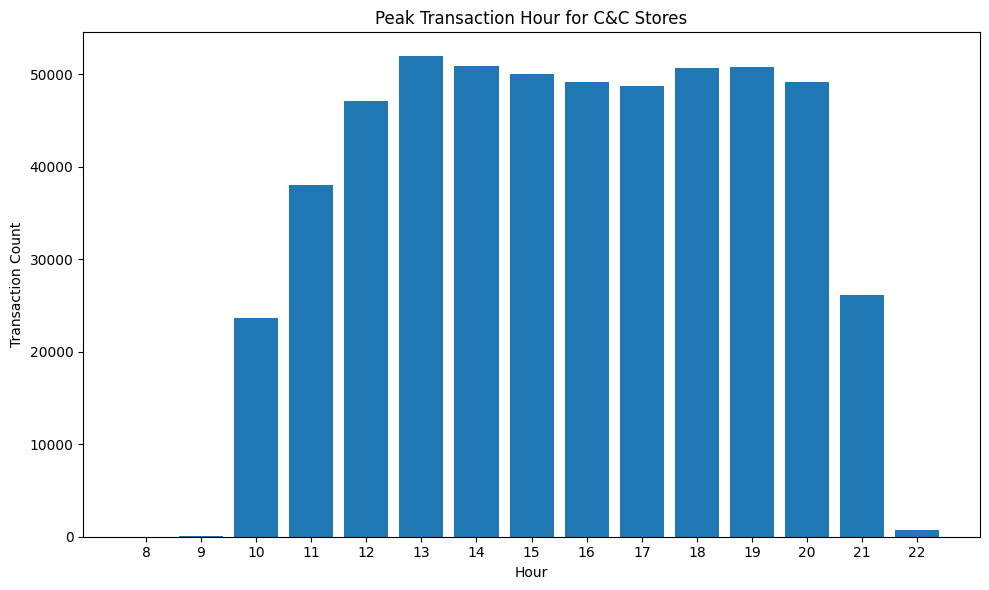

In [49]:
plt.figure(figsize=(10, 6))
plt.bar(transaction_counts['hour'], transaction_counts['count'])
plt.xlabel('Hour')
plt.ylabel('Transaction Count')
plt.title('Peak Transaction Hour for C&C Stores')
plt.xticks(transaction_counts['hour'])
plt.tight_layout()

In [50]:
df_online.head()

,the_transaction_id,the_date_transaction,sku_idr_sku,product_type,sports,but_name_business_unit,ctm_customer_id,the_to_type,f_qty_item,f_to_tax_in,hour,store_type
475,7-2459-2459-20200923214628-102-851,2020-09-23 21:46:28,1718267,NaN,NaN,Website,E1OWOWPT1K,online,5,110.5,21,Online
670,7-1034-1034-20200710102742-117-88,2020-07-10 10:27:42,7206544,WATER BOTTLE BE,RUNNING,Website,ZY8KCYC8O3,online,5,83.5,10,Online
786,7-1034-1034-20200704160615-117-27,2020-07-04 16:06:15,7204924,RUNNING MID TIG,RUNNING,Website,0VX6TTV6ES,online,2,98.5,16,Online
788,7-1034-1034-20200703124109-102-6434,2020-07-03 12:41:09,7231216,WATER BOTTLE BE,RUNNING,Website,OUSGNK1LLA,online,5,48.5,12,Online
826,7-1034-1034-20200803174610-118-52,2020-08-03 17:46:10,7209766,SHORTS,RUNNING,Website,POSTV6OQ9L,online,2,36.5,17,Online


In [51]:
transaction_counts = df_online.groupby(['hour']).size().reset_index(name='count')
peak_time_online = transaction_counts.loc[transaction_counts['count'].idxmax()]

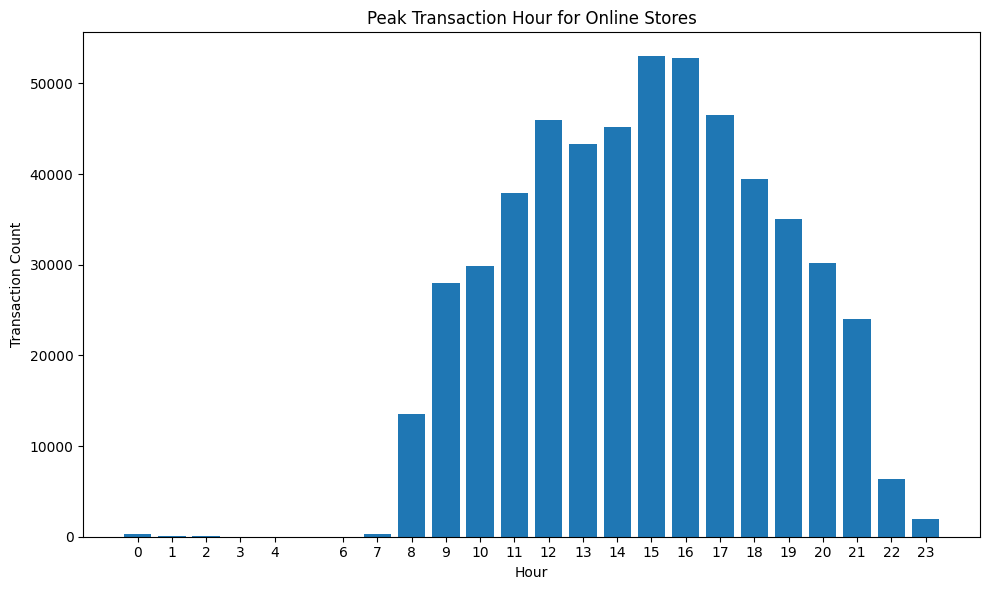

In [52]:
plt.figure(figsize=(10, 6))
plt.bar(transaction_counts['hour'], transaction_counts['count'])
plt.xlabel('Hour')
plt.ylabel('Transaction Count')
plt.title('Peak Transaction Hour for Online Stores')
plt.xticks(transaction_counts['hour'])
plt.tight_layout()

In [53]:

print(f"It is observed that the peak hour for Experience Stores are {peak_time_exp['hour']} hour with {peak_time_exp['count']} transactions \nC&C Stores are {peak_time_cc['hour']} hour with {peak_time_cc['count']} transactions \nOnline stores are {peak_time_online['hour']} hour with {peak_time_online['count']} transactions ")

It is observed that the peak hour for Experience Stores are 16 hour with 421308 transactions 
C&C Stores are 13 hour with 51938 transactions 
Online stores are 15 hour with 52974 transactions 


# Data Science (Optional)

## Forecasting

In [54]:
df['month'] = df['the_date_transaction'].dt.month

In [55]:
df['day'] = df['the_date_transaction'].dt.day

In [56]:
df['week'] = df['the_date_transaction'].dt.isocalendar().week.astype(int)

In [57]:
df.drop(columns = ['the_transaction_id', 'sku_idr_sku', 'ctm_customer_id', 'product_type'], axis= 1, inplace = True)

In [58]:
df['sports'].unique()

array([nan, 'RUGBY', 'RUNNING', 'MOUNTAIN', 'YOGA', 'KITE',
       'TABLE TENNIS', 'NETBALL', 'SURFING', 'TEAMSPORT', 'FIXT & FURNIT',
       'BOXING', 'CRICKET', 'WORKSHOP AND SERVICES', 'BADMINTON',
       'WATERSPORT', 'BODYBUILDING', 'CYCLING', 'HOCKEY', 'HANDBALL',
       'HUNTING', 'TENNIS', 'URBAN', 'VOLLEYBALL', 'SKATEBOARD',
       'PILATES', 'FITNESS', 'SAILING', 'SQUASH', 'DANCE', 'BASEBALL',
       'SKI', 'GOLF', 'GYMNASTICS', 'SWIMMING', 'NUTRITION ', 'TARGET',
       'FOOTBALL', 'HORSE RIDING', 'FISHING'], dtype=object)

In [59]:
df = df.sort_values('the_date_transaction')

In [60]:
df

,the_date_transaction,sports,but_name_business_unit,the_to_type,f_qty_item,f_to_tax_in,hour,store_type,month,day,week
643662,2020-07-01 08:19:44,FIXT & FURNIT,Singapore Lab,offline,6,155.0,8,Experience Stores,7,1,27
1002689,2020-07-01 08:19:44,BODYBUILDING,Singapore Lab,offline,5,43.5,8,Experience Stores,7,1,27
2228842,2020-07-01 08:19:44,FITNESS,Singapore Lab,offline,3,227.0,8,Experience Stores,7,1,27
4519084,2020-07-01 08:22:41,MOUNTAIN,Singapore Lab,offline,2,38.0,8,Experience Stores,7,1,27
2559604,2020-07-01 08:22:41,MOUNTAIN,Singapore Lab,offline,4,78.0,8,Experience Stores,7,1,27
...,...,...,...,...,...,...,...,...,...,...,...
448819,2020-12-31 23:11:18,SURFING,Singapore Lab,offline,1,25.5,23,Experience Stores,12,31,53
5264501,2020-12-31 23:11:18,FOOTBALL,Singapore Lab,offline,1,25.0,23,Experience Stores,12,31,53
87176,2020-12-31 23:11:18,YOGA,Singapore Lab,offline,4,98.5,23,Experience Stores,12,31,53
1491426,2020-12-31 23:11:18,VOLLEYBALL,Singapore Lab,offline,1,24.5,23,Experience Stores,12,31,53


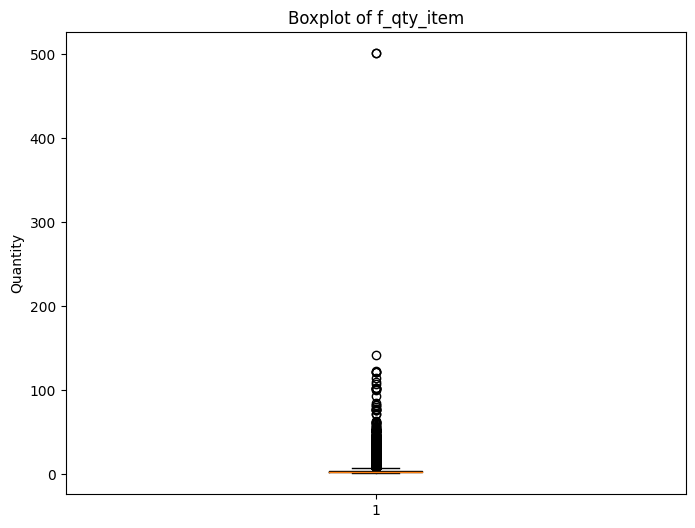

Interquartile Range (IQR) for f_qty_item: 2.0


In [61]:
plt.figure(figsize=(8, 6))
plt.boxplot(df['f_qty_item'])
plt.title('Boxplot of f_qty_item')
plt.ylabel('Quantity')
plt.show()

# Calculate the IQR for 'f_qty_item' column
Q1 = df['f_qty_item'].quantile(0.25)
Q3 = df['f_qty_item'].quantile(0.75)
IQR = Q3 - Q1

print("Interquartile Range (IQR) for f_qty_item:", IQR)

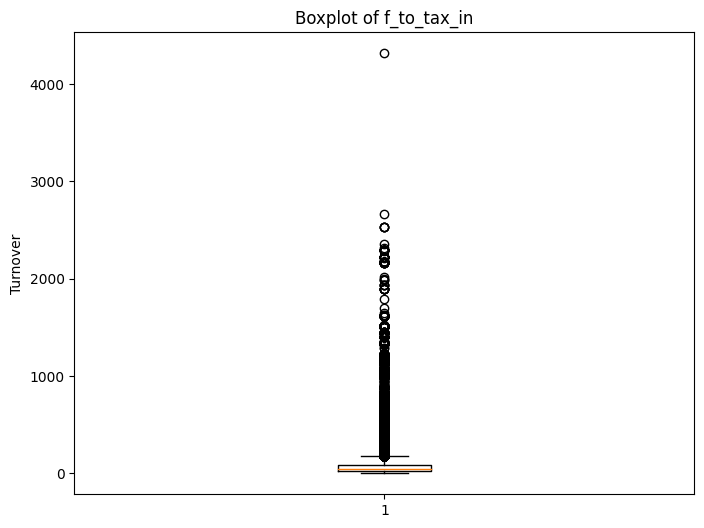

Interquartile Range (IQR) for f_qty_item: 61.5


In [62]:
plt.figure(figsize=(8, 6))
plt.boxplot(df['f_to_tax_in'])
plt.title('Boxplot of f_to_tax_in')
plt.ylabel('Turnover')
plt.show()

# Calculate the IQR for 'f_qty_item' column
Q1 = df['f_to_tax_in'].quantile(0.25)
Q3 = df['f_to_tax_in'].quantile(0.75)
IQR = Q3 - Q1

print("Interquartile Range (IQR) for f_qty_item:", IQR)

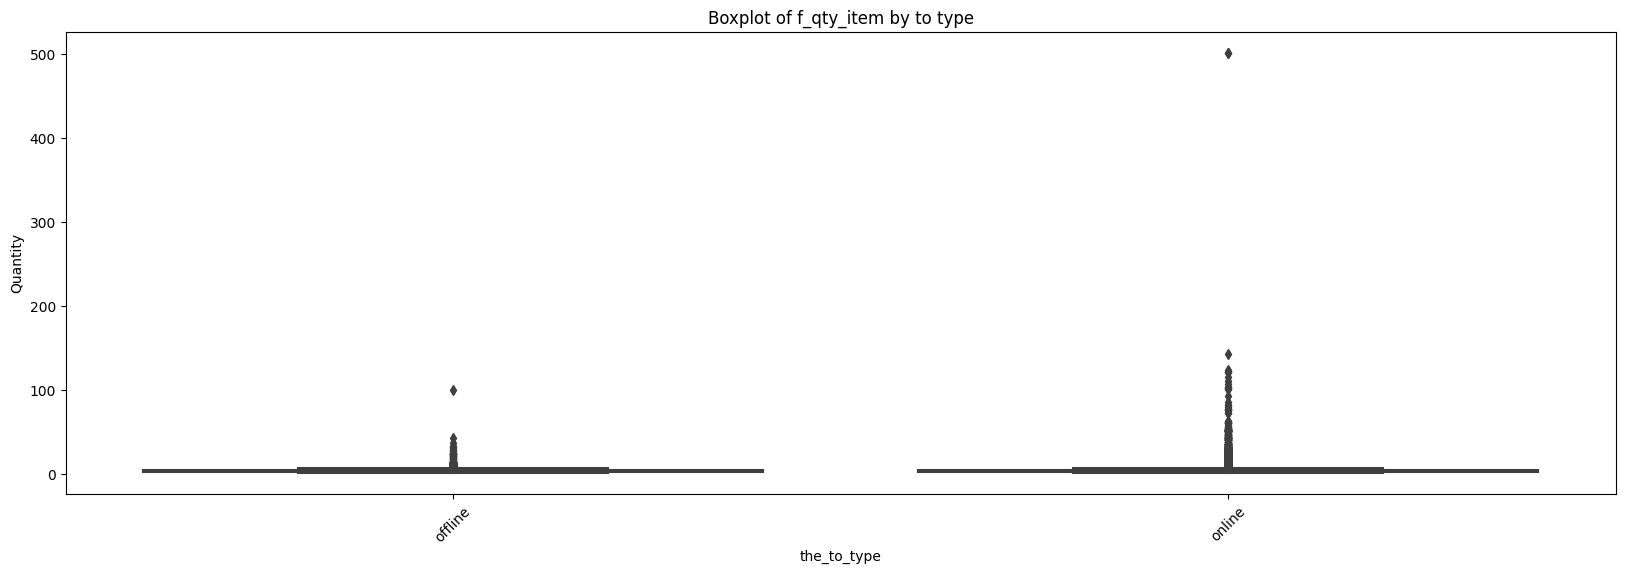

In [63]:
plt.figure(figsize=(20, 6))
sb.boxplot(x='the_to_type', y='f_qty_item', data=df)
plt.title('Boxplot of f_qty_item by to type')
plt.xticks(rotation=45)
plt.ylabel('Quantity')
plt.show()



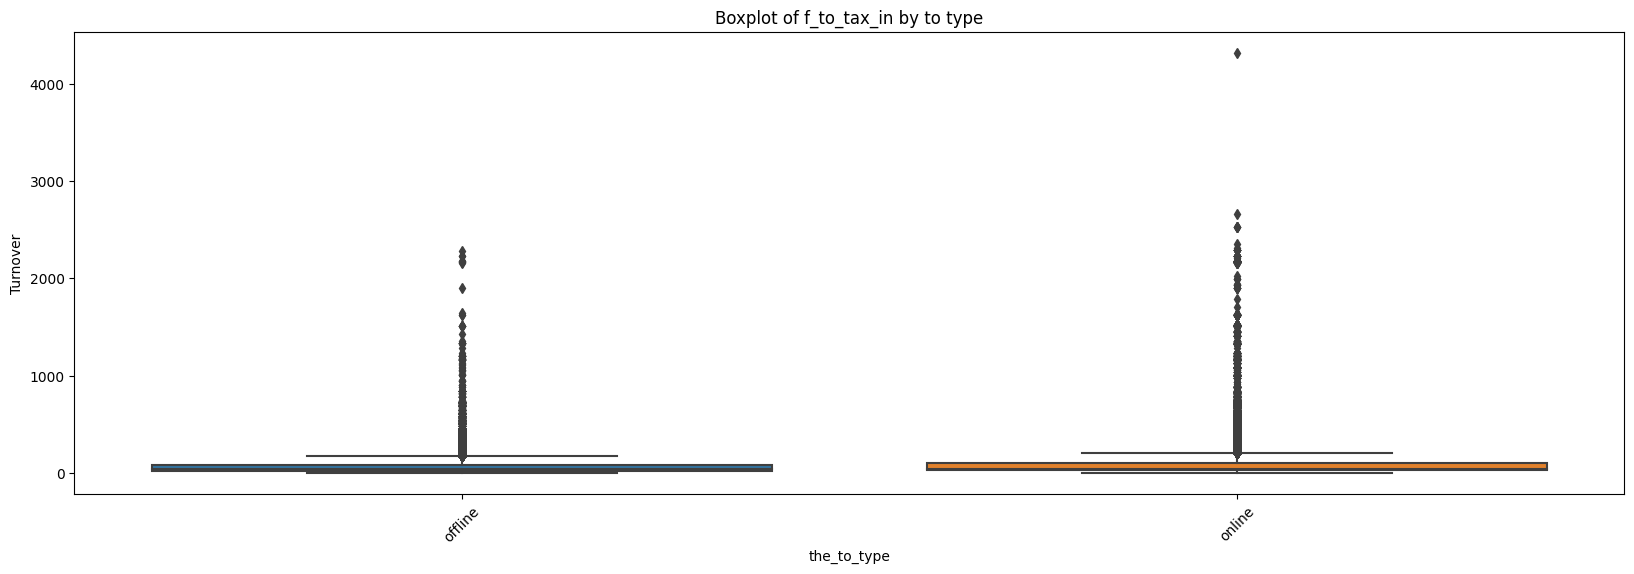

In [64]:
plt.figure(figsize=(20, 6))
sb.boxplot(x='the_to_type', y='f_to_tax_in', data=df)
plt.title('Boxplot of f_to_tax_in by to type')
plt.xticks(rotation=45)
plt.ylabel('Turnover')
plt.show()

In [65]:
df.query("the_to_type == 'offline' & f_to_tax_in> 2000")

,the_date_transaction,sports,but_name_business_unit,the_to_type,f_qty_item,f_to_tax_in,hour,store_type,month,day,week
1650958,2020-07-02 17:54:51,CYCLING,Bedok SG,offline,1,2175.0,17,Experience Stores,7,2,27
1500292,2020-07-23 12:30:30,CYCLING,City Square SG,offline,2,2168.0,12,Experience Stores,7,23,30
1676351,2020-09-10 22:03:03,CYCLING,Bedok SG,offline,1,2168.0,22,Experience Stores,9,10,37
1510252,2020-09-13 13:55:03,CYCLING,City Square SG,offline,2,2175.0,13,Experience Stores,9,13,37
1619405,2020-10-04 12:30:45,CYCLING,Centre Point,offline,2,2226.0,12,Experience Stores,10,4,40
1542697,2020-10-10 17:42:55,CYCLING,Joo Koon,offline,3,2159.5,17,Experience Stores,10,10,41
3303468,2020-10-25 14:20:27,CYCLING,Singapore Lab,offline,3,2283.5,14,Experience Stores,10,25,43
1524439,2020-11-23 21:41:08,CYCLING,City Square SG,offline,3,2226.0,21,Experience Stores,11,23,48


In [66]:
df.query("the_to_type == 'online' & f_to_tax_in> 2000")

,the_date_transaction,sports,but_name_business_unit,the_to_type,f_qty_item,f_to_tax_in,hour,store_type,month,day,week
1523131,2020-07-01 10:58:51,CYCLING,Website,online,3,2175.0,10,Online,7,1,27
1531379,2020-07-02 14:30:05,CYCLING,Website,online,2,2293.5,14,Online,7,2,27
1527871,2020-07-03 13:35:50,CYCLING,Website,online,4,2168.0,13,Online,7,3,27
3283647,2020-07-03 16:45:25,CYCLING,Website,online,4,2532.5,16,Online,7,3,27
1521677,2020-07-05 12:26:36,CYCLING,Website,online,1,2226.0,12,Online,7,5,27
1529624,2020-07-08 14:30:48,CYCLING,Website,online,1,2175.0,14,Online,7,8,28
1531603,2020-07-12 10:54:30,CYCLING,Website,online,3,2175.0,10,Online,7,12,28
1529549,2020-07-15 13:17:01,CYCLING,Website,online,2,2293.5,13,Online,7,15,29
1533554,2020-07-16 21:59:17,CYCLING,Website,online,5,2175.0,21,Online,7,16,29
3286638,2020-07-18 10:47:05,CYCLING,Website,online,2,2532.5,10,Online,7,18,29


In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5462787 entries, 643662 to 1491425
Data columns (total 11 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   the_date_transaction    datetime64[ns]
 1   sports                  object        
 2   but_name_business_unit  object        
 3   the_to_type             object        
 4   f_qty_item              int64         
 5   f_to_tax_in             float64       
 6   hour                    int32         
 7   store_type              object        
 8   month                   int32         
 9   day                     int32         
 10  week                    int32         
dtypes: datetime64[ns](1), float64(1), int32(4), int64(1), object(4)
memory usage: 416.8+ MB


Removing some drastic outliers, may help with the forecasting.<br>
Allowing the model to learn easier

In [68]:
df = df[df['f_to_tax_in'] <= 1000]

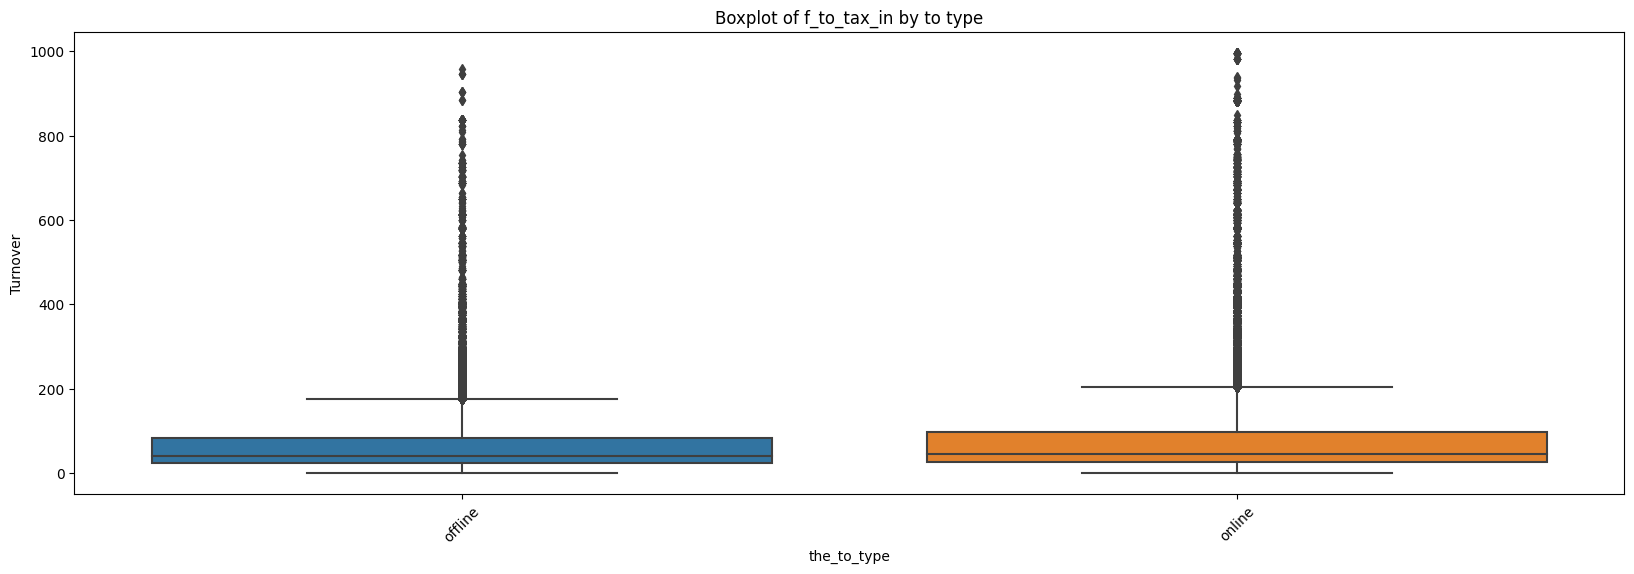

In [69]:
plt.figure(figsize=(20, 6))
sb.boxplot(x='the_to_type', y='f_to_tax_in', data=df)
plt.title('Boxplot of f_to_tax_in by to type')
plt.xticks(rotation=45)
plt.ylabel('Turnover')
plt.show()

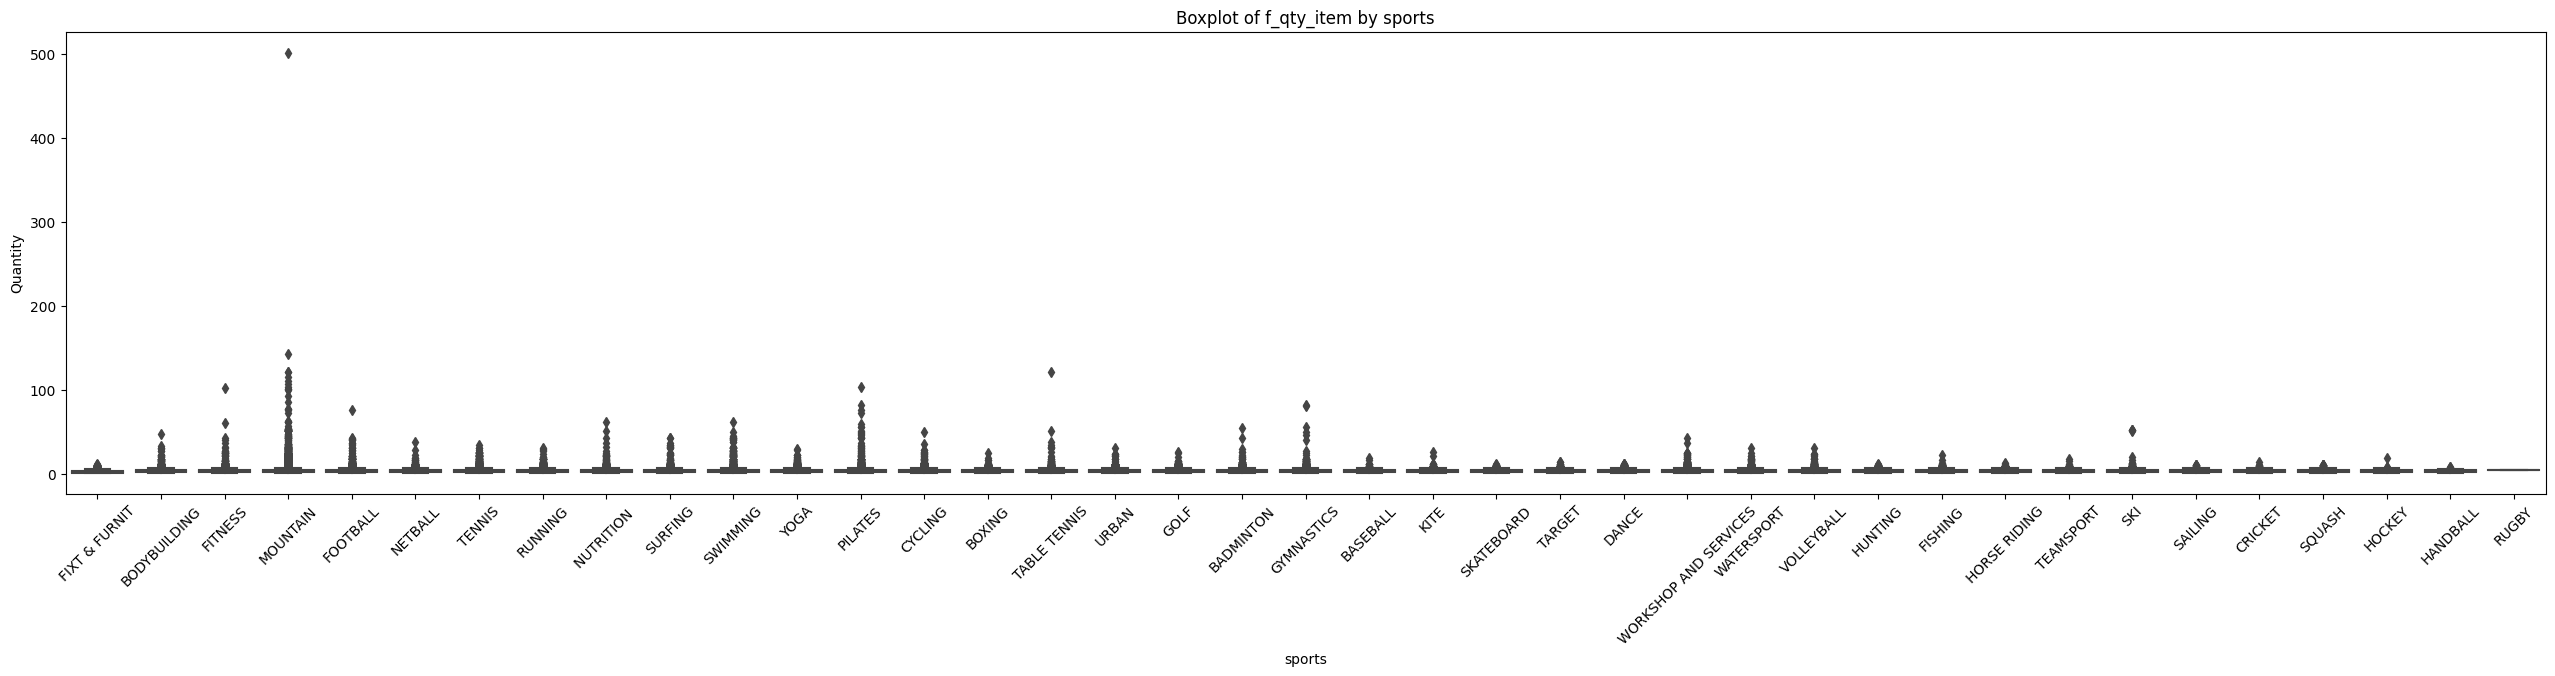

In [70]:
plt.figure(figsize=(32, 6))
sb.boxplot(x='sports', y='f_qty_item', data=df)
plt.title('Boxplot of f_qty_item by sports')
plt.xticks(rotation=45)
plt.ylabel('Quantity')
plt.show()

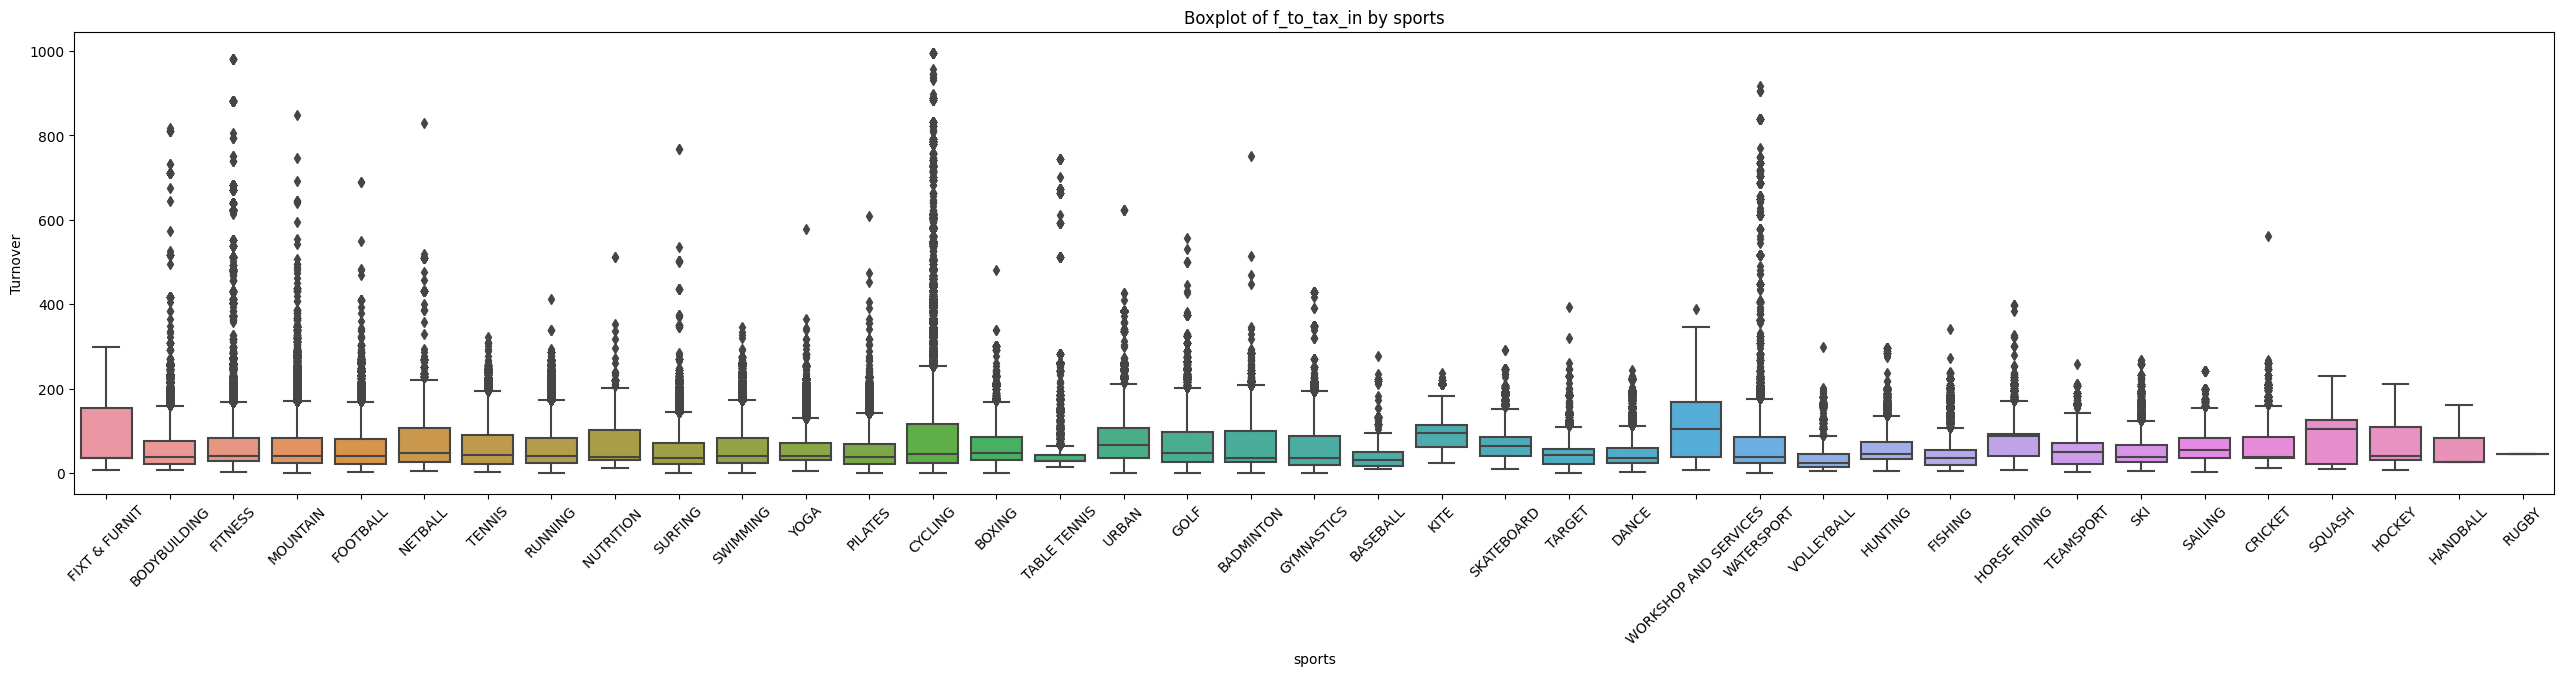

In [71]:
plt.figure(figsize=(32, 6))
sb.boxplot(x='sports', y='f_to_tax_in', data=df)
plt.title('Boxplot of f_to_tax_in by sports')
plt.xticks(rotation=45)
plt.ylabel('Turnover')
plt.show()

Seperate the transactions into offline and online

In [72]:
df_offline = df.loc[df['the_to_type'] == 'offline']
df_online = df.loc[df['the_to_type'] == 'online']

In [73]:
df_offline

,the_date_transaction,sports,but_name_business_unit,the_to_type,f_qty_item,f_to_tax_in,hour,store_type,month,day,week
643662,2020-07-01 08:19:44,FIXT & FURNIT,Singapore Lab,offline,6,155.0,8,Experience Stores,7,1,27
1002689,2020-07-01 08:19:44,BODYBUILDING,Singapore Lab,offline,5,43.5,8,Experience Stores,7,1,27
2228842,2020-07-01 08:19:44,FITNESS,Singapore Lab,offline,3,227.0,8,Experience Stores,7,1,27
4519084,2020-07-01 08:22:41,MOUNTAIN,Singapore Lab,offline,2,38.0,8,Experience Stores,7,1,27
2559604,2020-07-01 08:22:41,MOUNTAIN,Singapore Lab,offline,4,78.0,8,Experience Stores,7,1,27
...,...,...,...,...,...,...,...,...,...,...,...
448819,2020-12-31 23:11:18,SURFING,Singapore Lab,offline,1,25.5,23,Experience Stores,12,31,53
5264501,2020-12-31 23:11:18,FOOTBALL,Singapore Lab,offline,1,25.0,23,Experience Stores,12,31,53
87176,2020-12-31 23:11:18,YOGA,Singapore Lab,offline,4,98.5,23,Experience Stores,12,31,53
1491426,2020-12-31 23:11:18,VOLLEYBALL,Singapore Lab,offline,1,24.5,23,Experience Stores,12,31,53


In [74]:
df_online

,the_date_transaction,sports,but_name_business_unit,the_to_type,f_qty_item,f_to_tax_in,hour,store_type,month,day,week
2563771,2020-07-01 08:25:10,MOUNTAIN,Website,online,3,67.5,8,Online,7,1,27
5222638,2020-07-01 08:25:22,FOOTBALL,Website,online,2,18.0,8,Online,7,1,27
223676,2020-07-01 08:27:08,NETBALL,Website,online,2,39.0,8,Online,7,1,27
4518139,2020-07-01 08:30:17,MOUNTAIN,Website,online,6,38.0,8,Online,7,1,27
2982302,2020-07-01 08:30:52,RUNNING,Website,online,2,134.0,8,Online,7,1,27
...,...,...,...,...,...,...,...,...,...,...,...
2347761,2020-12-31 23:00:32,FITNESS,Website,online,1,44.5,23,Online,12,31,53
254431,2020-12-31 23:00:32,NETBALL,Website,online,4,33.0,23,Online,12,31,53
1068617,2020-12-31 23:00:32,BODYBUILDING,Website,online,2,21.0,23,Online,12,31,53
2334964,2020-12-31 23:00:32,FITNESS,Website,online,4,43.5,23,Online,12,31,53


First instinct is to aggregate the f_to_tax_in by months

In [75]:
df_online_agg = df_online.groupby(by = 'month').agg({'f_qty_item': 'sum', 'f_to_tax_in': 'sum'}).reset_index()

In [76]:
df_offline_agg = df_offline.groupby(by = 'month').agg({'f_qty_item': 'sum', 'f_to_tax_in': 'sum'}).reset_index()

In [77]:
df_online_agg

,month,f_qty_item,f_to_tax_in
0,7,181799,4357930.00
1,8,208305,4910483.20
2,9,213468,4934283.43
3,10,324327,7263700.47
4,11,417286,9185433.65
5,12,352300,7926045.01


In [78]:
df_offline_agg

,month,f_qty_item,f_to_tax_in
0,7,2265774,48510808.70
1,8,2132709,43012938.93
2,9,2094279,41567903.86
3,10,2472482,49589789.42
4,11,2563916,50489224.72
5,12,3138086,65278307.94


In [79]:
df_offline_agg.corr()

,month,f_qty_item,f_to_tax_in
month,1.000000,0.833845,0.724419
f_qty_item,0.833845,1.000000,0.983690
f_to_tax_in,0.724419,0.983690,1.000000


In [80]:
df_online_agg.corr()

,month,f_qty_item,f_to_tax_in
month,1.000000,0.894064,0.896161
f_qty_item,0.894064,1.000000,0.999761
f_to_tax_in,0.896161,0.999761,1.000000


Split the data to train and test

In [81]:
train_online_data = df_online_agg[:4]

In [82]:
test_online_data = df_online_agg[4:]

## ARIMA

### Online TO Type 

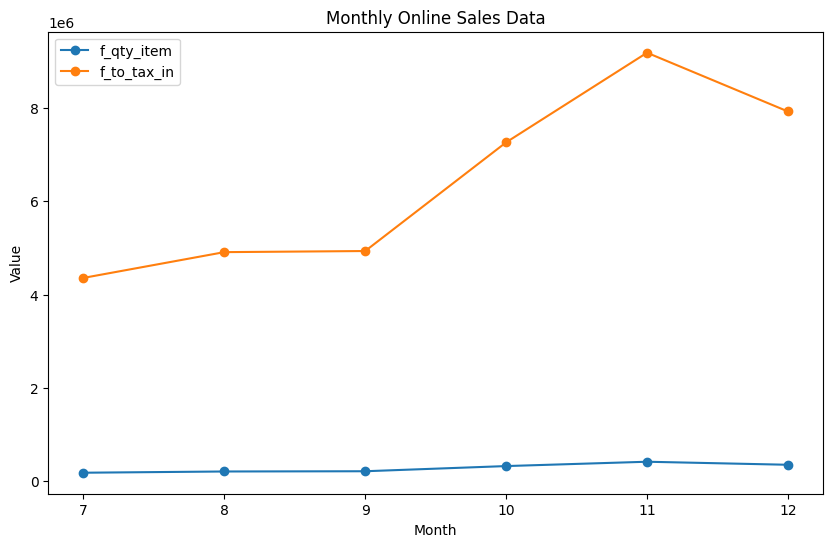

In [83]:
plt.figure(figsize=(10, 6))
plt.plot(df_online_agg['month'], df_online_agg['f_qty_item'], marker='o', label='f_qty_item')
plt.plot(df_online_agg['month'], df_online_agg['f_to_tax_in'], marker='o', label='f_to_tax_in')
plt.title('Monthly Online Sales Data')
plt.xlabel('Month')
plt.ylabel('Value')
plt.legend()
plt.show()


In [84]:

train_size = int(0.8 * len(df_online_agg))
train, test = df_online_agg['f_to_tax_in'][:train_size], df_online_agg['f_to_tax_in'][train_size:]

p, d, q = 1, 1, 1  
model = ARIMA(train, order=(p, d, q))
model_fit = model.fit()

predictions = model_fit.forecast(steps=len(test))

rmse = np.sqrt(mean_squared_error(test, predictions))
print("Root Mean Squared Error:", rmse)



Root Mean Squared Error: 1266705.2330618112


c:\Users\eric2\Desktop\decathlon\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


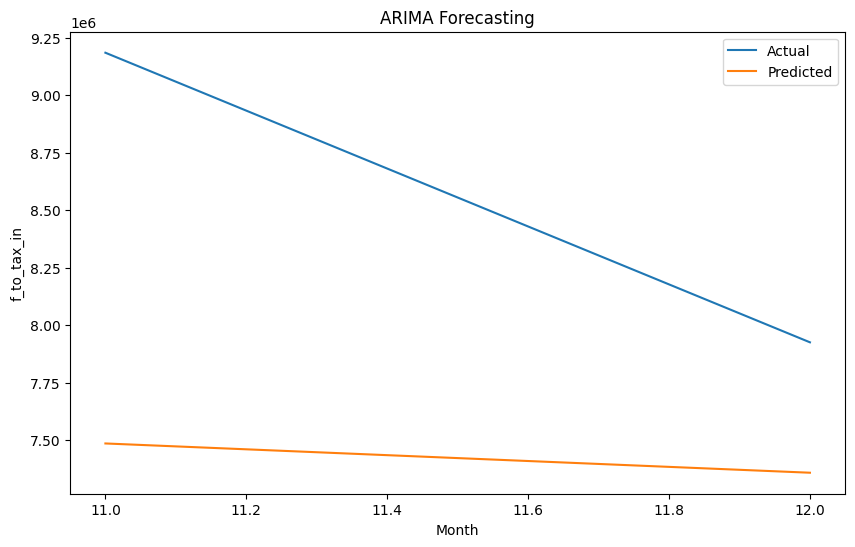

In [85]:

plt.figure(figsize=(10, 6))
plt.plot(df_online_agg['month'][train_size:], test, label='Actual')
plt.plot(df_online_agg['month'][train_size:], predictions, label='Predicted')
plt.title('ARIMA Forecasting')
plt.xlabel('Month')
plt.ylabel('f_to_tax_in')
plt.legend()
plt.show()

### Offline TO Type 

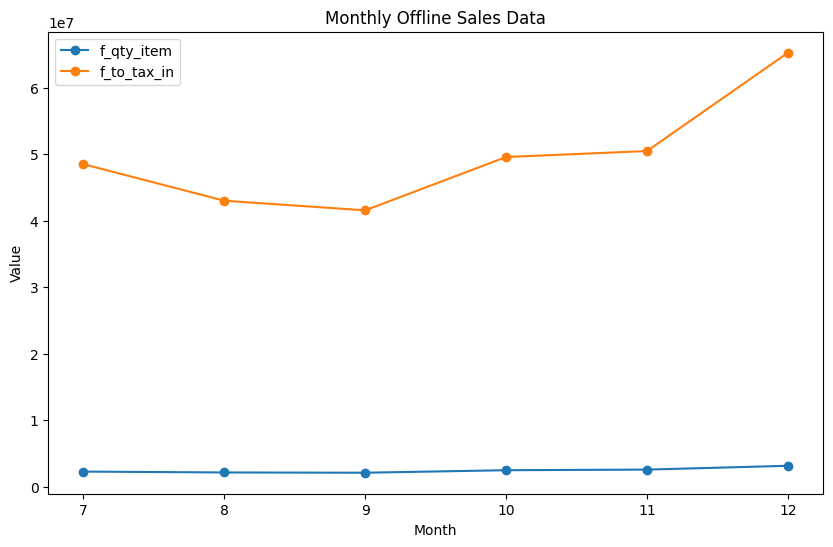

In [86]:
plt.figure(figsize=(10, 6))
plt.plot(df_offline_agg['month'], df_offline_agg['f_qty_item'], marker='o', label='f_qty_item')
plt.plot(df_offline_agg['month'], df_offline_agg['f_to_tax_in'], marker='o', label='f_to_tax_in')
plt.title('Monthly Offline Sales Data')
plt.xlabel('Month')
plt.ylabel('Value')
plt.legend()
plt.show()


In [87]:

train_size = int(0.8 * len(df_online_agg))
train, test = df_online_agg['f_to_tax_in'][:train_size], df_online_agg['f_to_tax_in'][train_size:]


p, d, q = 1, 1, 1 
model = ARIMA(train, order=(p, d, q))
model_fit = model.fit()

predictions = model_fit.forecast(steps=len(test))


rmse = np.sqrt(mean_squared_error(test, predictions))
print("Root Mean Squared Error:", rmse)



Root Mean Squared Error: 1266705.2330618112


c:\Users\eric2\Desktop\decathlon\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


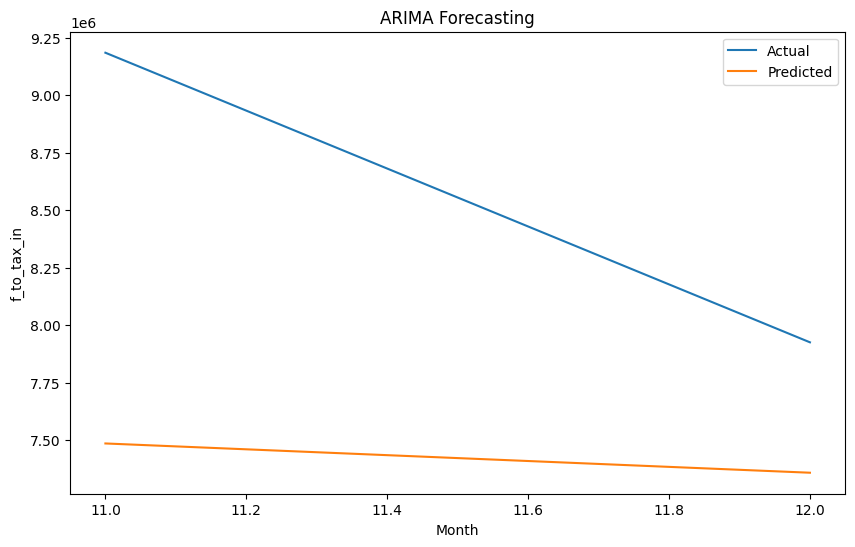

In [88]:

plt.figure(figsize=(10, 6))
plt.plot(df_online_agg['month'][train_size:], test, label='Actual')
plt.plot(df_online_agg['month'][train_size:], predictions, label='Predicted')
plt.title('ARIMA Forecasting')
plt.xlabel('Month')
plt.ylabel('f_to_tax_in')
plt.legend()
plt.show()

### Utilising Month and f_qty_item features

In [89]:
X = df_online_agg[['month', 'f_qty_item']]
y = df_online_agg['f_to_tax_in']

In [90]:
num_folds = 3
kf = KFold(n_splits = num_folds)

mse_scores = []
mae_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)
    
    mae = mean_absolute_error(y_test,y_pred)
    mae_scores.append(mae)

average_mse = sum(mse_scores) / len(mse_scores)
print("Average MSE:", average_mse)

average_mae = sum(mae_scores) / len(mae_scores)
print("Average MAE:", average_mae)

Average MSE: 14770349499.242928
Average MAE: 106413.23595782323


In [91]:
num_folds = 3
kf = KFold(n_splits = num_folds)

mse_scores = []
mae_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model = DecisionTreeRegressor()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)
    
    mae = mean_absolute_error(y_test,y_pred)
    mae_scores.append(mae)

average_mse = sum(mse_scores) / len(mse_scores)
print("Average MSE:", average_mse)

average_mae = sum(mae_scores) / len(mae_scores)
print("Average MAE:", average_mae)

Average MSE: 1359688883010.4187
Average MAE: 854960.7983333333


In [92]:
num_folds = 3
kf = KFold(n_splits = num_folds)

mse_scores = []
mae_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model = XGBRegressor()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)
    
    mae = mean_absolute_error(y_test,y_pred)
    mae_scores.append(mae)

average_mse = sum(mse_scores) / len(mse_scores)
print("Average MSE:", average_mse)

average_mae = sum(mae_scores) / len(mae_scores)
print("Average MAE:", average_mae)

Average MSE: 817296935234.6816
Average MAE: 645063.07


In [93]:
num_folds = 3
kf = KFold(n_splits = num_folds)

mse_scores = []
mae_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
   
    model = RandomForestRegressor()
    model.fit(X_train, y_train)
   
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)
    
    mae = mean_absolute_error(y_test,y_pred)
    mae_scores.append(mae)

average_mse = sum(mse_scores) / len(mse_scores)
print("Average MSE:", average_mse)

average_mae = sum(mae_scores) / len(mae_scores)
print("Average MAE:", average_mae)

Average MSE: 2266608758954.657
Average MAE: 1216745.1621833292


## Market Basket Analysis

In [94]:
df_market = df_market[(df_market['the_to_type'] == 'online')]

In [95]:
df_market = df_market[~df_market['product_type'].isnull()]


In [96]:
df_market

,the_transaction_id,the_date_transaction,sku_idr_sku,product_type,sports,but_name_business_unit,ctm_customer_id,the_to_type,f_qty_item,f_to_tax_in,hour,store_type
670,7-1034-1034-20200710102742-117-88,2020-07-10 10:27:42,7206544,WATER BOTTLE BE,RUNNING,Website,ZY8KCYC8O3,online,5,83.5,10,Online
786,7-1034-1034-20200704160615-117-27,2020-07-04 16:06:15,7204924,RUNNING MID TIG,RUNNING,Website,0VX6TTV6ES,online,2,98.5,16,Online
788,7-1034-1034-20200703124109-102-6434,2020-07-03 12:41:09,7231216,WATER BOTTLE BE,RUNNING,Website,OUSGNK1LLA,online,5,48.5,12,Online
826,7-1034-1034-20200803174610-118-52,2020-08-03 17:46:10,7209766,SHORTS,RUNNING,Website,POSTV6OQ9L,online,2,36.5,17,Online
853,7-1034-1034-20200806162105-118-106,2020-08-06 16:21:05,6979056,GAITERS,RUNNING,Website,EPUKREL1IS,online,5,35.5,16,Online
...,...,...,...,...,...,...,...,...,...,...,...,...
5496717,7-969-969-20201207123120-216-7465,2020-12-07 12:31:20,1193174,SOCKS,RUNNING,Website,XM96LOF6TJ,online,3,158.5,12,Online
5496720,7-969-969-20201211110637-216-7803,2020-12-11 11:06:37,7142503,SHOES,RUNNING,Website,DOS68FJC21,online,2,201.0,11,Online
5496724,7-969-969-20201215171347-216-8331,2020-12-15 17:13:47,7193288,SHOES,RUNNING,Website,ZSIUWYHEWG,online,3,41.0,17,Online
5496740,7-969-969-20201224103331-216-9311,2020-12-24 10:33:31,7004104,SCALE,RUNNING,Website,UDJNEBOWQ8,online,3,16.5,10,Online


In [97]:
df_market['product_type'].value_counts()[:15]

product_type
T-SHIRT            44176
SHORTS             40858
SOCKS              19516
SHOES              14579
BACKPACK           14548
TANK               11367
TROUSERS            9921
DUMBBELL            9378
HELMET              8396
LEGGINGS            8191
TOP                 8135
TOWEL               8071
WATER BOTTLE        7771
SWIMMING GOGGLE     6891
ELASTIC BAND        6179
Name: count, dtype: int64

In [98]:
df_market.sort_values('the_transaction_id')

,the_transaction_id,the_date_transaction,sku_idr_sku,product_type,sports,but_name_business_unit,ctm_customer_id,the_to_type,f_qty_item,f_to_tax_in,hour,store_type
4785849,7-1034-1034-20200701112936-102-6101,2020-07-01 11:29:36,768052,TROUSERS,MOUNTAIN,Website,TA22SYNHPR,online,3,14.0,11,Online
4785850,7-1034-1034-20200701112936-102-6101,2020-07-01 11:29:36,2106576,TROUSERS,MOUNTAIN,Website,TA22SYNHPR,online,1,27.0,11,Online
2513426,7-1034-1034-20200701112936-102-6101,2020-07-01 11:29:36,7341455,SHORTS,MOUNTAIN,Website,TA22SYNHPR,online,1,170.0,11,Online
4788217,7-1034-1034-20200701114220-102-6102,2020-07-01 11:42:20,7200852,BACKPACK,MOUNTAIN,Website,OS529R2SBF,online,5,85.5,11,Online
4788208,7-1034-1034-20200701114220-102-6102,2020-07-01 11:42:20,7200852,BACKPACK,MOUNTAIN,Website,OS529R2SBF,online,3,85.5,11,Online
...,...,...,...,...,...,...,...,...,...,...,...,...
1677107,7-969-969-20201231213532-215-9561,2020-12-31 21:35:32,1769129,SADDLE BAG,CYCLING,Website,OIOYOD48F8,online,2,14.0,21,Online
5401534,7-969-969-20201231213922-216-174,2020-12-31 21:39:22,5143720,CHILD BIKE,CYCLING,Website,17HMLVV5M4,online,2,295.0,21,Online
549980,7-969-969-20201231214031-215-9562,2020-12-31 21:40:31,7008837,FLIP-FLOPS,SURFING,Website,KLXI8YA0S7,online,2,35.5,21,Online
1683710,7-969-969-20201231214031-215-9563,2020-12-31 21:40:31,1769129,SADDLE BAG,CYCLING,Website,OIOYOD48F8,online,3,14.0,21,Online


In [99]:
grouped_df = df_market.groupby('the_transaction_id')['product_type'].apply(set).apply(list).reset_index()

In [100]:
grouped_df.drop('the_transaction_id', axis = 1, inplace = True)

In [101]:
grouped_df.head()

,product_type
0,"[SHORTS, TROUSERS]"
1,[BACKPACK]
2,[BACKPACK]
3,[TOWEL]
4,[YOGA MAT]


The basket is formed from the transactions that contain the list of product types purchased

In [102]:
basket = pd.get_dummies(grouped_df['product_type'].apply(pd.Series).stack()).groupby(level=0).sum()
basket[basket > 1] = 1  

frequent_itemsets = apriori(basket, min_support=0.008, use_colnames=True)




c:\Users\eric2\Desktop\decathlon\venv\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [103]:
basket.info()

<class 'pandas.core.frame.DataFrame'>
Index: 193787 entries, 0 to 193786
Columns: 757 entries, 1-PIECE SWIMSUI to YOGA MAT
dtypes: int64(757)
memory usage: 1.1 GB


There are 193787 Transactions and 757 types of product that is sold in decathlon online

In [104]:
basket.head()

,1-PIECE SWIMSUI,2 PIECES SWIMSU,3/4 CYCLING BIB,ABDOMINAL WHEEL,ABS EQUIPMENT,ADAPTOR,ADHESIVE TAPE,AFTER SUN LOTIO,ALIGNEMENT STIC,ALIGNMENT STICK,AMERICAN FOOT B,ANKLE BRACE,ANKLE BRACE SUP,ANKLE STRAP,ANTI-CHAFING CR,ANTI-FOGGING,ANTI-VIBRATION,AQUASHOES,ARM GUARD,ARROW,ARROW NOCK,ARROW PULLER,ARROW REST,ATHLETICS SPIKE,BABY AQUATIC CA,BABY SEAT MOUNT,BABY SEAT SWIN,BACK PROTECTION,BACKPACK,BADMINTON NET,BADMINTON RACKE,BAG,BAG COVER,BAG SUPPORT,BAIT PUMP,BALACLAVA,BALANCE BIKE,BALANCE BOARD,BALANCE DISC,BALL,BALL BASKET,BALL COLLECTOR,BALL MARKER,BALL NEEDLE,BALL NET,BALL RETRIEVER,BALL STENCIL,BAR,BAR ENDS,BARBELL PAD,BASE LAYER,BASEBALL,BASEBALL BAT,BASELAYER BOTTO,BASKET,BASKET BALL,BASKETBALL NET,BATTERY,BEACH TENNIS NE,BEACH TENNIS RA,BEANIE,BEARING,BELAY GLASSES,BELL,BELT,BERMUDA SHORTS,BIB,BIB SHORTS,BIKE CLEANER,BIKE COMPUTER,BIKE HOOK,BIKE LIGHT,BIKE PANNIER,BIKE PUMP'S HEA,BIKE RACK,BIKE SADDLE,BIKE STABILISER,BIKINI,BIKINI BOTTOM,BIKINI TOP,BINDING,BINDINGS MODULE,BINOCULAR HARNESS,BINOCULARS,BITS,BLADDER,BLADE CLEANER,BLANKET,BLISTER PROTECT,BOARDBAG,BOARDSHORTS,BOAT ROPES,BODY ARMOUR,BODY PROTECTOR,BODY-BOARD,BOLSTER,BOOMERANG,BOOTIES,BOTTLE CAGE,BOTTLE CAGE BOL,BOTTLE CAP,BOTTLE HOLDER,BOTTLE RACK,BOULE,BOULES CIRCLE,BOW,BOW SIGHT,BOW STRING,BOWL,BOXER SHORTS,BOXERS,BOXING GLOVES,BOXING HAND WRA,BRA,BRA EXTENDER,BRAID FISHING L,BRAKE,BRAKE CABLE,BRAKE CABLE END,BRAKE CALLIPER,BRAKE DISC,BRAKE KIT,BRAKE LEVER,BRAKE PAD,BRAKE PADS,BREECHES,BRIDLE,BRIEFS,BRUSH,BRUSHING BOOTS,BUN KIT,BUOYANCY BELT,BUOYANCY VEST,CABLE AND HOUSI,CALF COMPRESSIO,CALF SUPPORT,CAMERA MOUNT,CAMP BED,CAMP STOVE,CAMPING TABLE,CAP,CAPTAIN'S ARMBA,CARRY CASE,CASSETTE,CEREAL BAR,CHAIN,CHAIN TOOL,CHAINSET,CHAINSET GUARD,CHAIR,CHALK BAG,CHANGING ROBE,CHARGER,CHEST LAMP,CHEST STRAP,CHILD BIKE,CHILD BIKE SEAT,CHIPPING NET,CLAMPING STRAP,CLEANSING WIPE,CLEATED SHOES,CLIMBING ACCESS,CLIMBING CHALK,CLIMBING HOLD,CLIMBING LANYAR,CLIMBING ROPE,CLIMBING SLIPPE,CLIP,CLIP ON AEROBAR,COACHING FOLDER,COLD PACK,COMB,COMPASS,COMPRESSION SOC,COMPRESSION SUP,COMPUTER COVER,CONE,COOKSET,COOLER BOX,CORRECTIVE LENS,CRAMPON ANTIBAL,CRICKET BAT,CROPPED LEGGING,CROPPED TROUSER,CROSS TRAINER,CRUISER SKATE,CUE TIPS,CUP,CURRY COMB,CUSHION,CUTLERY,CYCLE RACK,CYCLING SHORTS,DART,DART SHAFT,DART TIP,DARTBOARD,DARTBOARD SURRO,DARTS FEATHER,DECK,DEGREASER,DEODORANT,DERAILER PROTEC,DERAILLEUR,DERAILLEUR CABL,DERAILLEUR HOSE,DESCRIPTION HOL,DIPS STATION,DISPOSABLE SWIMMING PANTIES,DIVING MOUTHPIECE,DIVING REGULATO,DIVOT TOOL,DOBOK,DOODAD STRAPS,DOWN JACKET,DRESS,DRINK,DRIVER,DRIVER HEAD COV,DUMBBELL,DUMBBELLS KIT,DYNAMO LIGHT,EARPHONE,EARPLUG,ELASTIC,ELASTIC BAND,ELASTIC TRAININ,ELBOW GUARD,ELBOW SUPPORT,ELECTRIC PUMP,ENERGY GEL,EXERCISE BIKE,FAIRWAY WOODS,FASTENING BUCKL,FEATHER SHUTTLE,FEEDER,FETLOCK BOOTS,FIELD MARKERS,FIN,FINGER SUPPORT,FIRST-AID KIT,FIT OVER SUNGLA,FITNESS MAT,FITNESS TOWER,FIVE A SIDE FOO,FLASH LIGHT,FLEECE,FLIP CHART,FLIP-FLOPS,FLOAT,FLOOR PUMP,FLUOROCARBON FI,FLYING DISC,FOAM MAT,FOAM PAD,FOAM ROLLER,FOCUS PAD,FOLDING BIKE,FOLDING CHAIR,FOOD BOX,FOOD JAR,FOOT BALL,FOOT PROTECTION,FOOTBALL BOOTS,FRAME BAG,FRAME PROTECTIO,FREE WHEEL,FREEZER PACK,FULL BODY SWIMS,FUTSAL SHOES,GAITERS,GEAR SHIFTER,GIRTH,GLASSES CASE,GLASSES CLIP,GLASSES STRAP,GLIDING DISC,GLOVE DRYER,GLOVE LINER,GLOVES,GOAL,GOALKEEPER GLOV,GOLF BAG,GOLF BALL,GOLF CHIPPER,GOLF SET,GOLF SHOES,GOLF SINGLE IRO,GPS,GRAPPLING GLOVE,GRIP,GRIP TAPE,GROIN GUARD,GROOMING BAG,GROOMING BOX,GROUNDSHEET,GUIDE PIPE AND,GYM BALL BASE,GYMNASTICS GRIP,HALF CHAPS,HALF PADS,HALF-POINT,HAMMOCK,HAND MASSAGER,HAND PUMP,HAND PUMP HOSE,HAND/FOOT-WARME,HANDGRIP,HANDLE,HANDLEBAR,HANDLEBAR BAG,HANDLEBAR CAP,HANDLEBAR TAPE,HARDBAIT,HARNESS,HAT,HEADBAND,HEADCOLLAR,HEADLAMP,HEART RATE MONI,HEEL PAD,HELMET,HELMET CASE,HIKING POLE,HOCKEY GLOVE,HOCKEY STICK,HOCKEY STICK BA,HOME GYM,HOOF BRUSH,HOOF PICK,HOOK KNIFE,HOOKS,HOOP,HORN,HOT / COLD PACK,HYBRID BIKE,HYBRID GOLF CLU,ICE BAG,ICE SKATE,INLINE SKATES,INNER GLOVES,INN

In [105]:
frequent_itemsets

,support,itemsets
0,0.016704,(1-PIECE SWIMSUI)
1,0.011332,(AQUASHOES)
2,0.039156,(BACKPACK)
3,0.014758,(BADMINTON RACKE)
4,0.010088,(BALL)
5,0.011523,(BASKET BALL)
6,0.012700,(BELL)
7,0.012746,(BIKE LIGHT)
8,0.021395,(BOARDSHORTS)
9,0.015682,(BOTTLE CAGE)


Understanding the Association Rules.
- Antecedents: The set of product types that are present that are observed in a transaction and used as a starting point to make predictions of another set of items.
- Consequent: The set of items that is being predicted or recommended based on antecedent
- Antecdent Support: The proportion of transactions that contain the anteceedent set of the product types
- Consequent Support: The proportion of transactions that contain the consequent set of the product types
- support: The proportion of transactions that contain both the antecedent and consequent sets of product types
- confidence: The probability of the consequent set of product types being purchased given the antecedent set of product types is purchased. confidence = support/antecedent support
- lift: Measures how likely the consequent set of product is to be purhcased when the antecedent set of product types is being purcahsed, compared to if they were purcahsed independently and at random.

In [106]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=0.5)

print(rules)

          antecedents        consequents  antecedent support  \
0           (T-SHIRT)         (LEGGINGS)            0.116994   
1          (LEGGINGS)          (T-SHIRT)            0.032082   
2             (SHOES)           (SHORTS)            0.057574   
3            (SHORTS)            (SHOES)            0.129797   
4             (SHOES)            (SOCKS)            0.057574   
5             (SOCKS)            (SHOES)            0.068746   
6             (SHOES)          (T-SHIRT)            0.057574   
7           (T-SHIRT)            (SHOES)            0.116994   
8            (SHORTS)            (SOCKS)            0.129797   
9             (SOCKS)           (SHORTS)            0.068746   
10           (SHORTS)          (T-SHIRT)            0.129797   
11          (T-SHIRT)           (SHORTS)            0.116994   
12           (SHORTS)             (TANK)            0.129797   
13             (TANK)           (SHORTS)            0.039791   
14           (SHORTS)         (TROUSERS)

In [107]:
filtered_rules = rules[rules['antecedents'].apply(lambda x: list(x) == sorted(x))]

# Print the filtered rules
print(filtered_rules)

          antecedents        consequents  antecedent support  \
0           (T-SHIRT)         (LEGGINGS)            0.116994   
1          (LEGGINGS)          (T-SHIRT)            0.032082   
2             (SHOES)           (SHORTS)            0.057574   
3            (SHORTS)            (SHOES)            0.129797   
4             (SHOES)            (SOCKS)            0.057574   
5             (SOCKS)            (SHOES)            0.068746   
6             (SHOES)          (T-SHIRT)            0.057574   
7           (T-SHIRT)            (SHOES)            0.116994   
8            (SHORTS)            (SOCKS)            0.129797   
9             (SOCKS)           (SHORTS)            0.068746   
10           (SHORTS)          (T-SHIRT)            0.129797   
11          (T-SHIRT)           (SHORTS)            0.116994   
12           (SHORTS)             (TANK)            0.129797   
13             (TANK)           (SHORTS)            0.039791   
14           (SHORTS)         (TROUSERS)

In [108]:
min_confidence_threshold = 0.1
min_support_threshold = 0.01

interesting_rules = rules[
    (rules['confidence'] >= min_confidence_threshold) &
    (rules['support'] >= min_support_threshold)
]

In [109]:
interesting_rules.sort_values('confidence', ascending = False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
13,(TANK),(SHORTS),0.039791,0.129797,0.016823,0.422773,3.257180,0.011658,1.507557,0.721703
11,(T-SHIRT),(SHORTS),0.116994,0.129797,0.045184,0.386203,2.975437,0.029998,1.417738,0.751881
18,(TANK),(T-SHIRT),0.039791,0.116994,0.015326,0.385164,3.292157,0.010671,1.436165,0.725100
10,(SHORTS),(T-SHIRT),0.129797,0.116994,0.045184,0.348110,2.975437,0.029998,1.354531,0.762943
1,(LEGGINGS),(T-SHIRT),0.032082,0.116994,0.010888,0.339392,2.900924,0.007135,1.336656,0.677002
21,(TROUSERS),(T-SHIRT),0.036953,0.116994,0.010192,0.275799,2.357373,0.005868,1.219283,0.597893
9,(SOCKS),(SHORTS),0.068746,0.129797,0.018200,0.264750,2.039722,0.009277,1.183547,0.547366
16,(SOCKS),(T-SHIRT),0.068746,0.116994,0.016322,0.237427,2.029386,0.008279,1.157929,0.544685
6,(SHOES),(T-SHIRT),0.057574,0.116994,0.010764,0.186968,1.598092,0.004029,1.086065,0.397117
2,(SHOES),(SHORTS),0.057574,0.129797,0.010140,0.176123,1.356907,0.002667,1.056229,0.279098


From the interesting apriori association rules, with the given thoughts of support and confidence which have shown that the antecedent and consequent happening in the dataset is a common trend, <br>the following should be considered to be bundled based on research.
- [TANK, SHORTS]
- [T-SHIRT, SHORTS]
- [TANK, T-SHIRT]
- [SHORTS, T-SHIRT]
- [LEGGINGS, T-SHIRT]